<a href="https://colab.research.google.com/github/VictorGlezDiez/VIU_TFM_TimeSeries/blob/master_VIU/Matric_DIARIO_shock_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Máster en Big Data y Data Science - Visualización de datos**

**Víctor González Díez**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.google.es"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://www.google.es"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Ver en GitHub</a>
  </td>
      <td>
    <a href="https://www.google.es"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Descargar notebook</a>
  </td>
</table>

##**<font color=grey>Instalar paquetes y librerías</font>**

####**Paquete `tbats`**

In [ ]:
!pip install tbats

     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 1.4 MB 22.2 MB/s 
     |████████████████████████████████| 9.8 MB 54.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


####**Paquete `Prophet`**


In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639941 sha256=f5261194170f96b31b3c7987a89935cd26fdd8dc7305c84264736dd3f41f9572
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


####**Instalar librerías**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

In [ ]:
# Para cargar los datos
import io
from google.colab import files

In [ ]:
# Análisis
from pandas.plotting import autocorrelation_plot # funciones autocorrelación
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición estacional
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller
from scipy.stats import boxcox # transformación box-cox
from scipy.special import inv_boxcox # invertir transformación box-cox
import math, time
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error # rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.collections import PolyCollection, LineCollection
import statsmodels.api as sm
from numpy.random import seed

In [ ]:
# Modelos
from pmdarima import auto_arima
from pmdarima.preprocessing import FourierFeaturizer
from tbats import TBATS, BATS
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly # Gráficos dinámicos en Prophet
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # holt winters single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # holt winters double and triple exponential smoothing
import xgboost as xgb # XGBoost
from xgboost import plot_importance, plot_tree
import tensorflow_probability as tfp # Tensorflow

# Para RNR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

####**Definir funciones**

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

##**<font color=grey>Cargar datos</font>**

In [ ]:
uploaded = files.upload()
xlsx_file = io.BytesIO(uploaded.get('matric.xlsx'))
df_raw = pd.read_excel(xlsx_file, 'python')
df_raw.tail()

TypeError: ignored

#**<font color='FF663'>Estudio comparativo de técnicas de series temporales: métodologías tradicionales vs. Machine Learning</font>**

##**<font color=FF6633>Transformación de los datos</font>**

In [ ]:
# Crear fecha completa: año, mes y día
df_raw['date_matric'] = pd.to_datetime(df_raw[["year", "month", "day"]])
df_raw = df_raw.drop(['year', 'month', 'day'], axis=1)
df_raw = df_raw[['date_matric', "mercado", "canal", "unidades"]]

In [ ]:
# Seleccionar solo el mercado de turismos
df_TURTT = df_raw[(df_raw['mercado']=='TUR') |
                  (df_raw['mercado']=='TT')]

# Agregar datos por MERCADO
df_TURTT = pd.DataFrame(df_TURTT.groupby([df_TURTT['date_matric'], df_TURTT['canal']])['unidades'].sum()).reset_index()

In [ ]:
# Poner canales en columnas y crear total canales
print('Los canales son:',df_TURTT['canal'].unique())
df_TURTT_canal = df_TURTT.pivot(index="date_matric", columns="canal", values="unidades").reset_index().rename_axis(None, axis=1)

# Fijar fecha como índice
df_TURTT_canal = df_TURTT_canal.set_index('date_matric')

# Columna de total canales
df_TURTT_canal['total'] = df_TURTT_canal['ALQUILADOR'] + df_TURTT_canal['EMPRESA'] + df_TURTT_canal['PARTICULAR']

Los canales son: ['ALQUILADOR' 'EMPRESA' 'PARTICULAR']


In [ ]:
# Outliers: si entre los tres canales no alcanzan las 10 unidades
df_TURTT_canal = df_TURTT_canal[df_TURTT_canal['total']>10]

In [ ]:
df_TURTT_canal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3017 entries, 2010-01-04 to 2021-12-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ALQUILADOR  3017 non-null   float64
 1   EMPRESA     3017 non-null   float64
 2   PARTICULAR  3017 non-null   float64
 3   total       3017 non-null   float64
dtypes: float64(4)
memory usage: 117.9 KB


Seleccionar el periodo de datos a utilizar

In [ ]:
data = df_TURTT_canal['2011-01-01':'2021-12-31']
data.head()

,ALQUILADOR,EMPRESA,PARTICULAR,total
date_matric,,,,
2011-01-03,86.0,1447.0,2162.0,3695.0
2011-01-04,159.0,1220.0,2314.0,3693.0
2011-01-05,44.0,809.0,1571.0,2424.0
2011-01-07,46.0,538.0,810.0,1394.0
2011-01-10,264.0,481.0,628.0,1373.0


In [ ]:
data.describe().round(2)

##**<font color=FF6633>Modelo - *Shock* negativo**</font>

Se comprobará el poder de predicción de los siguientes modelos:
* SARIMAX ✅
* SARIMAX con series de Fourier ✅
* TBATS ✅
* Holt-Winters ✅
* Facebook Prophet ✅
* XGBoost ✅
* RNN: LSTM y GRU ✅

###**<font color=21A5FF>SARIMAX</font>** [datos mensuales, semanales y diarios]

##### **PUNTO DE PARTIDA: Datos mensuales**

In [ ]:
# Mensualizar los datos
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-12)]
validacion = month_ts[int(len(month_ts)-12):]

In [ ]:
# Predicción
%time arima_model = auto_arima(entrenamiento, seasonal=True, m=12)

CPU times: user 11.8 s, sys: 9.74 s, total: 21.6 s
Wall time: 11.3 s


In [ ]:
print(arima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1311.542
Date:                              Wed, 13 Apr 2022   AIC                           2629.084
Time:                                      13:50:51   BIC                           2637.422
Sample:                                           0   HQIC                          2632.470
                                              - 120                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9333      0.073     12.857      0.000       0.791       1.076
ma.S.L12      -0.67

In [ ]:
y_arima_forecast = arima_model.predict(n_periods=len(validacion))
y_arima_forecast = pd.DataFrame(y_arima_forecast,index = validacion.index,columns=['Prediction']) # para obtener fechas de las previsiones

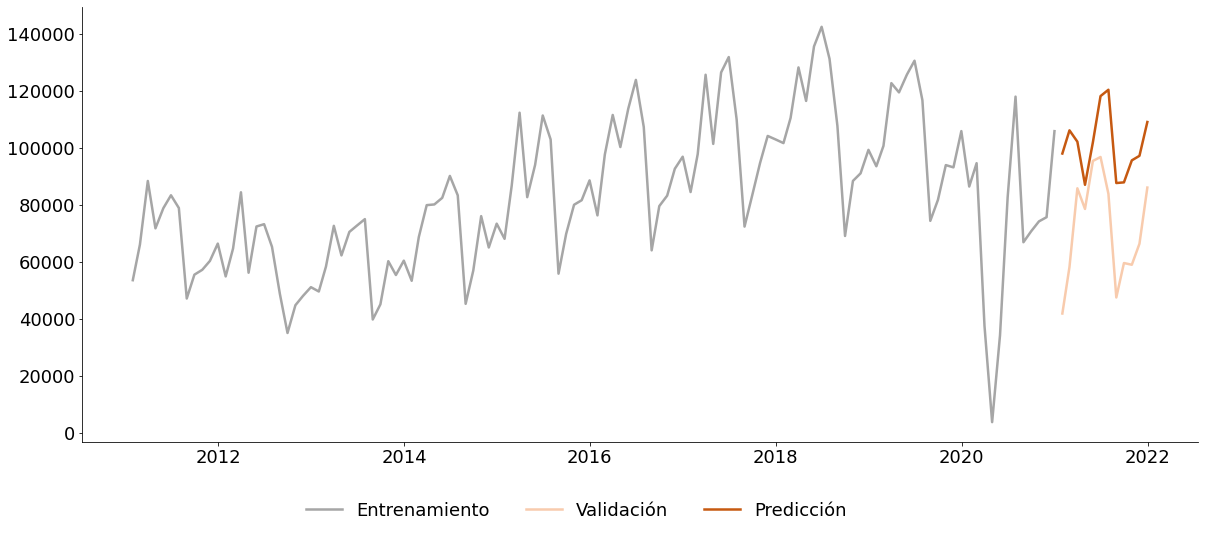

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(y_arima_forecast, label="Predicción", color="#C65911", linewidth=2.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_sarima_month_LT = sqrt(mean_squared_error(validacion,y_arima_forecast))
print(rms_sarima_month_LT)

# RMSE - 3 mes
rms_sarima_month_MT = sqrt(mean_squared_error(validacion[:3],y_arima_forecast[:3]))
print(rms_sarima_month_MT)

# RMSE - 1 mes
rms_sarima_month_ST = sqrt(mean_squared_error(validacion[:1],y_arima_forecast[:1]))
print(rms_sarima_month_ST)

32674.10448154755
43572.20719458441
56037.064871830546


##### **El problema de los datos diarios**

Los modelos SARIMA tienen dos desventajas principalmente:

1. Solo puede modelizar un único efecto estacional
2. La longitud de la estacionalidad no debe ser demasiado larga.

Se ignorará la estacionalidad anual (problema de fijar la estacionalidad en 365) para centrarnos en la estaiconalidad semanal.

In [ ]:
# Dato diario
day_ts = data['total']

In [ ]:
date_cut = '2020-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
%time arima_model = auto_arima(entrenamiento, seasonal=True, m=7)

CPU times: user 3min 21s, sys: 2min 25s, total: 5min 46s
Wall time: 2min 58s


In [ ]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2513
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -22938.921
Date:                             Wed, 13 Apr 2022   AIC                          45891.841
Time:                                     13:53:50   BIC                          45932.643
Sample:                                          0   HQIC                         45906.651
                                            - 2513                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3595      0.067     -5.404      0.000      -0.490      -0.229
ar.L2          0.4072      

In [ ]:
# Predicción
y_arima_forecast = arima_model.predict(n_periods=len(validacion))
y_arima_forecast = pd.DataFrame(y_arima_forecast,index = validacion.index,columns=['Prediction']) # para obtener fechas de las previsiones

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


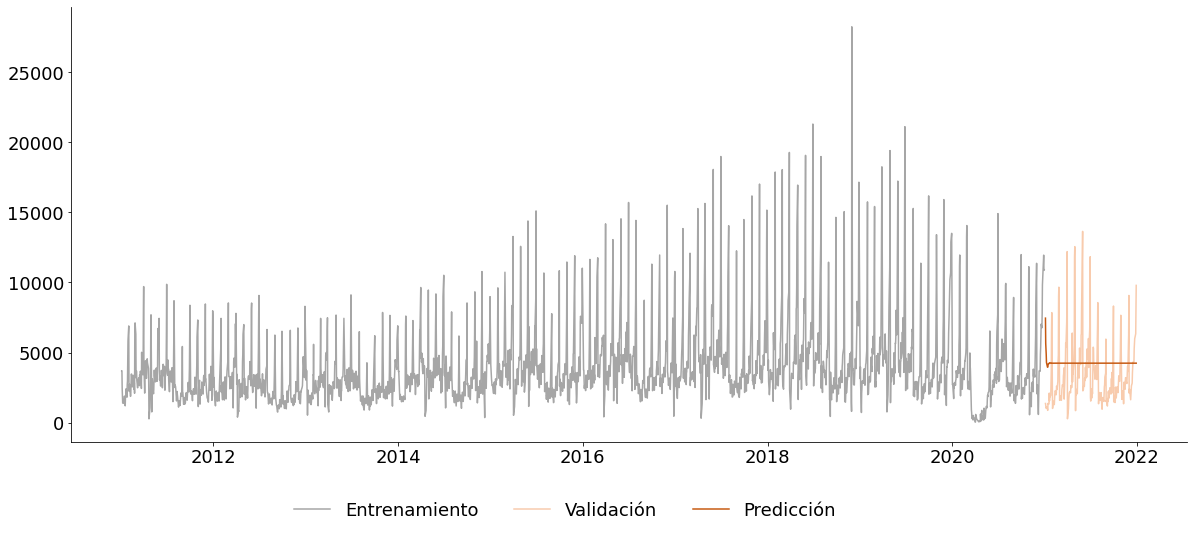

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_sarima_day_LT = sqrt(mean_squared_error(validacion,y_arima_forecast))
print(rms_sarima_day_LT)

# RMSE - 3 mes
rms_sarima_day_MT = sqrt(mean_squared_error(validacion[:66],y_arima_forecast[:66]))
print(rms_sarima_day_MT)

# RMSE - 1 mes
rms_sarima_day_ST = sqrt(mean_squared_error(validacion[:22],y_arima_forecast[:22]))
print(rms_sarima_day_ST)

2459.680155630551
2823.6735479653075
3082.903713198913


###**<font color=21A5FF>SARIMAX with Fourier terms</font>**

#####**Dato diario**

In [ ]:
# Dato diario
day_ts = data['total']

In [ ]:
# Preparar los términos de Fourier para añadirlos como variables exógenas al ARIMA
# Se cubre la estacionalidad anual con los términos de Fourier
four_terms = FourierFeaturizer(365.25, 4)
y_prime, exog_365 = four_terms.fit_transform(day_ts)
exog_365['date_matric'] = y_prime.index 
exog_365 = exog_365.set_index(exog_365['date_matric'])
#exog.index.freq = 'D'
exog_365 = exog_365.drop(columns=['date_matric'])

In [ ]:
# Preparar los términos de Fourier para añadirlos como variables exógenas al ARIMA
# Se cubre la estacionalidad mensual con los términos de Fourier
four_terms = FourierFeaturizer(30, 4)
y_prime, exog_30 = four_terms.fit_transform(day_ts)
exog_30['date_matric'] = y_prime.index 
exog_30 = exog_30.set_index(exog_30['date_matric'])
#exog.index.freq = 'D'
exog_30 = exog_30.drop(columns=['date_matric'])

In [ ]:
date_cut = '2020-12-31'
start_en = y_prime.index.searchsorted(pd.to_datetime(min(y_prime.index)))
end_en = y_prime.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = y_prime.iloc[start_en:end_en]
start_va = y_prime.index.searchsorted(pd.to_datetime(date_cut))
end_va = y_prime.index.searchsorted(pd.to_datetime(max(y_prime.index)))
validacion = y_prime.iloc[start_va:end_va]

start_en = exog_365.index.searchsorted(pd.to_datetime(min(exog_365.index)))
end_en = exog_365.index.searchsorted(pd.to_datetime(date_cut))
exog_365_entrenamiento = exog_365.iloc[start_en:end_en]
start_va = exog_365.index.searchsorted(pd.to_datetime(date_cut))
end_va = exog_365.index.searchsorted(pd.to_datetime(max(exog_365.index)))
exog_365_validacion = exog_365.iloc[start_va:end_va]

start_en = exog_30.index.searchsorted(pd.to_datetime(min(exog_30.index)))
end_en = exog_30.index.searchsorted(pd.to_datetime(date_cut))
exog_30_entrenamiento = exog_30.iloc[start_en:end_en]
start_va = exog_30.index.searchsorted(pd.to_datetime(date_cut))
end_va = exog_30.index.searchsorted(pd.to_datetime(max(exog_30.index)))
exog_30_validacion = exog_30.iloc[start_va:end_va]

exog_entrenamiento = exog_365_entrenamiento.merge(exog_30_entrenamiento, on='date_matric')
exog_validacion = exog_365_validacion.merge(exog_30_validacion, on='date_matric')

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


In [ ]:
%time arima_exog_model = auto_arima(y=entrenamiento, exogenous=exog_entrenamiento, seasonal=True, m=7)

CPU times: user 4min 33s, sys: 4min 57s, total: 9min 31s
Wall time: 4min 53s


In [ ]:
print(arima_exog_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2513
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -22941.961
Date:                Wed, 13 Apr 2022   AIC                          45927.922
Time:                        13:58:43   BIC                          46056.156
Sample:                             0   HQIC                         45974.465
                               - 2513                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.5886      2.272      0.259      0.796      -3.864       5.042
FOURIER_S365-0   123.5040    183.791      0.672      0.502    -236.721     483.729
FOURIER_C365-0   409.5364    174.649

In [ ]:
# Predicción
y_arima_exog_forecast = arima_exog_model.predict(n_periods=len(validacion), exogenous=exog_validacion)
y_arima_exog_forecast = pd.DataFrame(y_arima_exog_forecast, index = validacion.index, columns=['Prediction']) # para obtener fechas de las previsiones

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


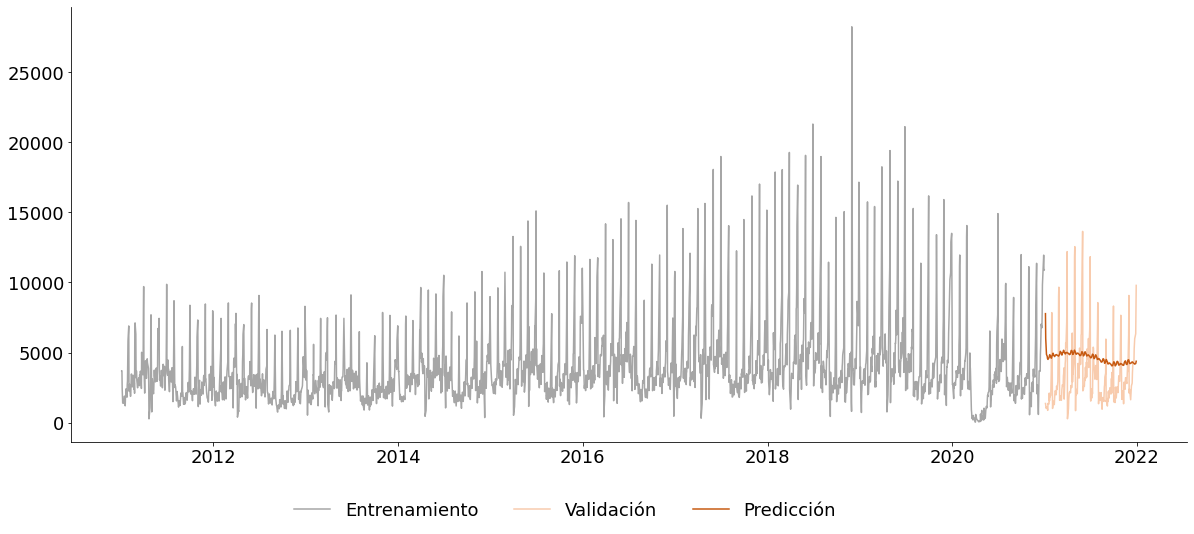

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_exog_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_sarimafourier_day_LT = sqrt(mean_squared_error(validacion,y_arima_exog_forecast))
print(rms_sarimafourier_day_LT)

# RMSE - 3 mes
rms_sarimafourier_day_MT = sqrt(mean_squared_error(validacion[:66],y_arima_exog_forecast[:66]))
print(rms_sarimafourier_day_MT)

# RMSE - 1 mes
rms_sarimafourier_day_ST = sqrt(mean_squared_error(validacion[:22],y_arima_exog_forecast[:22]))
print(rms_sarimafourier_day_ST)

2596.001206503047
3162.199502126302
3495.214126536085


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


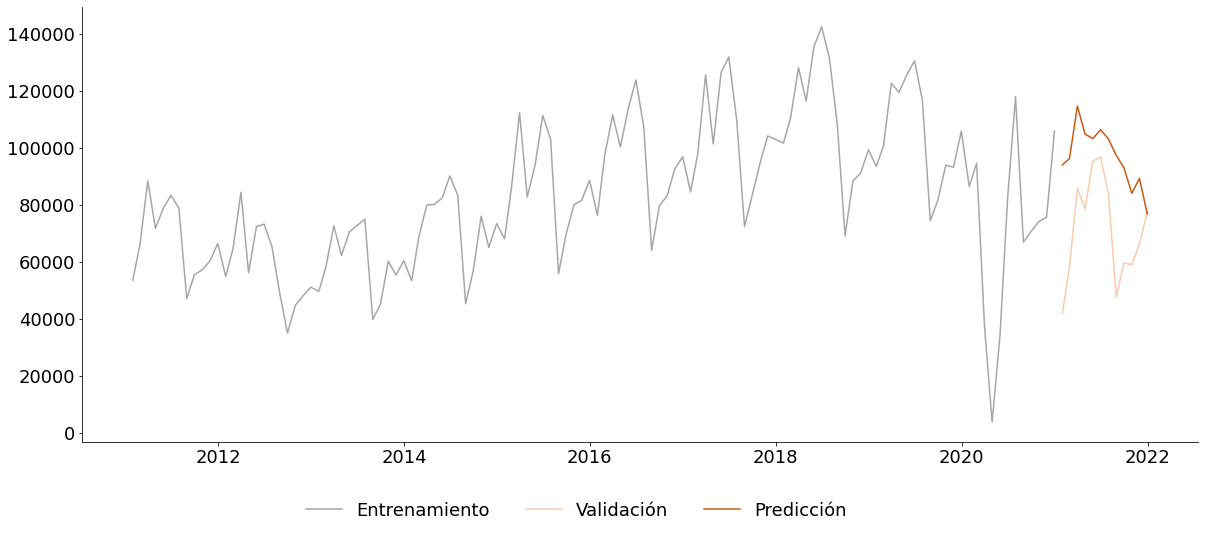

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(y_arima_exog_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_sarimafourier_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),y_arima_exog_forecast.resample('M').apply(sum)))
print(rms_sarimafourier_month_LT)

# RMSE - 3 mes
rms_sarimafourier_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],y_arima_exog_forecast.resample('M').apply(sum)[:3]))
print(rms_sarimafourier_month_MT)

# RMSE - 1 mes
rms_sarimafourier_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],y_arima_exog_forecast.resample('M').apply(sum)[:1]))
print(rms_sarimafourier_month_ST)

30177.5966391111
40746.197695750765
52058.7042298092


###**<font color=21A5FF>Holt-Winters</font>**

#####**Previo**

In [ ]:
# Utilziar el periodo completo
periodo_completo = pd.DataFrame({'date_matric': pd.date_range(start = data.index.min(),
                                                              end = data.index.max(),
                                                              freq='D')})

day_ts = periodo_completo.merge(data['total'], how='outer', on='date_matric')
day_ts['total'] = day_ts['total'].fillna(1)

day_ts = day_ts.set_index('date_matric')
day_ts.head()

,total
date_matric,
2011-01-03,3695.0
2011-01-04,3693.0
2011-01-05,2424.0
2011-01-06,1.0
2011-01-07,1394.0


In [ ]:
date_cut = '2021-01-01'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Fijar valor de Alpha y definir el periodo temporal
m = 365
alpha = 1/(2*365)

#####**Prueba: suavizado simple (Single Exponential Smoothing)**

El suavizado siempre no funciona cuando el conjuto de datos está afectado tanto por tendencia y estacionalidad.

In [ ]:
model_HWES1 = SimpleExpSmoothing(entrenamiento).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


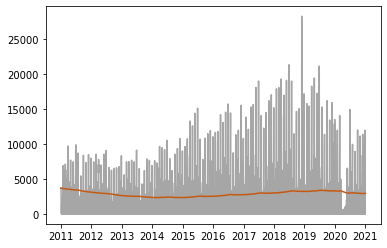

In [ ]:
plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(model_HWES1, label="Modelo", color="#C65911", linewidth=1.5)

#####**Prueba: suavizado doble (Double Exponential Smoothing)**

El siguiente paso es probar con el suavizado doble en ambos formatos posibles (adivitvo y multiplicativo). FUncionará mejor pero será con el triple suavizado cuando se termine de modelizar correctamente la estacionalidad de la serie.

In [ ]:
model_HWES2_ADD = ExponentialSmoothing(entrenamiento,trend='add').fit().fittedvalues
model_HWES2_MUL = ExponentialSmoothing(entrenamiento,trend='mul').fit().fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


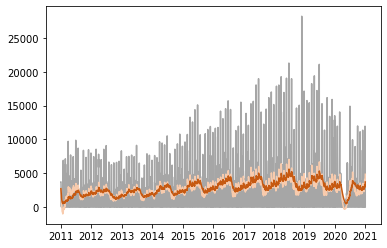

In [ ]:
plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(model_HWES2_ADD, label="Modelo aditivo", color="#F8CBAD", linewidth=1.5)
plt.plot(model_HWES2_MUL, label="Modelo multiplicativo", color="#C65911", linewidth=1.5)

##### **Datos diarios**

In [ ]:
print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-01 00:00:00  -  2021-12-29 00:00:00


In [ ]:
%time model_HWES3_ADD_ADD = ExponentialSmoothing(entrenamiento,trend='add',seasonal='add',seasonal_periods=365, damped_trend = True).fit()

forecast_HW_ADD_ADD = model_HWES3_ADD_ADD.forecast(len(validacion))
forecast_HW_ADD_ADD = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_ADD.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_ADD = forecast_HW_ADD_ADD.set_index('date_matric')
forecast_HW_ADD_ADD = forecast_HW_ADD_ADD[forecast_HW_ADD_ADD.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


CPU times: user 976 ms, sys: 12.6 ms, total: 989 ms
Wall time: 1.55 s


In [ ]:
%time model_HWES3_MUL_MUL = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='mul',seasonal_periods=365, damped_trend = True).fit()

forecast_HW_MUL_MUL = model_HWES3_MUL_MUL.forecast(len(validacion))
forecast_HW_MUL_MUL = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_MUL.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_MUL = forecast_HW_MUL_MUL.set_index('date_matric')
forecast_HW_MUL_MUL = forecast_HW_MUL_MUL[forecast_HW_MUL_MUL.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


CPU times: user 5min 16s, sys: 1.06 s, total: 5min 17s
Wall time: 5min 20s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_ADD_MUL = ExponentialSmoothing(entrenamiento,trend='add',seasonal='mul',seasonal_periods=365, damped_trend = False).fit()

forecast_HW_ADD_MUL = model_HWES3_ADD_MUL.forecast(len(validacion))
forecast_HW_ADD_MUL = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_MUL.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_MUL = forecast_HW_ADD_MUL.set_index('date_matric')
forecast_HW_ADD_MUL = forecast_HW_ADD_MUL[forecast_HW_ADD_MUL.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


CPU times: user 1.86 s, sys: 13.3 ms, total: 1.87 s
Wall time: 2.05 s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_ADD = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='ADD',seasonal_periods=365, damped_trend = True).fit()

forecast_HW_MUL_ADD = model_HWES3_MUL_ADD.forecast(len(validacion))
forecast_HW_MUL_ADD = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_ADD.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_ADD = forecast_HW_MUL_ADD.set_index('date_matric')
forecast_HW_MUL_ADD = forecast_HW_MUL_ADD[forecast_HW_MUL_ADD.index.dayofweek < 5] # Eliminar los fines de semana

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


CPU times: user 3min 48s, sys: 667 ms, total: 3min 49s
Wall time: 3min 51s


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

In [ ]:
# RMSE - 1 año
rms_HW_ADD_ADD_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_ADD_ADD))
rms_HW_MUL_MUL_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_MUL_MUL))
rms_HW_ADD_MUL_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_ADD_MUL))
rms_HW_MUL_ADD_day_LT = sqrt(mean_squared_error(validacion_sinfindes,forecast_HW_MUL_ADD))

print("ADD-ADD:", rms_HW_ADD_ADD_day_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_day_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_day_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_day_LT)

ADD-ADD: 1896.0770867055726
MUL-MUL: 2243.1887700687817
ADD-MUL: 2174.8656645489436
MUL-ADD: 1873.0724667083073


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_ADD_ADD[:66]))
rms_HW_MUL_MUL_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_MUL_MUL[:66]))
rms_HW_ADD_MUL_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_ADD_MUL[:66]))
rms_HW_MUL_ADD_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],forecast_HW_MUL_ADD[:66]))

print("ADD-ADD:", rms_HW_ADD_ADD_day_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_day_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_day_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_day_MT)

ADD-ADD: 1706.516509752733
MUL-MUL: 2262.232883498784
ADD-MUL: 2195.4612349963627
MUL-ADD: 1700.584001222257


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_ADD_ADD[:22]))
rms_HW_MUL_MUL_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_MUL_MUL[:22]))
rms_HW_ADD_MUL_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_ADD_MUL[:22]))
rms_HW_MUL_ADD_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],forecast_HW_MUL_ADD[:22]))

print("ADD-ADD:", rms_HW_ADD_ADD_day_ST)
print("MUL-MUL:", rms_HW_MUL_MUL_day_ST)
print("ADD-MUL:", rms_HW_ADD_MUL_day_ST)
print("MUL-ADD:", rms_HW_MUL_ADD_day_ST)

ADD-ADD: 883.536646482892
MUL-MUL: 1939.6715873095516
ADD-MUL: 1868.4850581904332
MUL-ADD: 891.8205342950502


Entrenamiento: 2011-01-03 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-01 00:00:00  -  2021-12-29 00:00:00


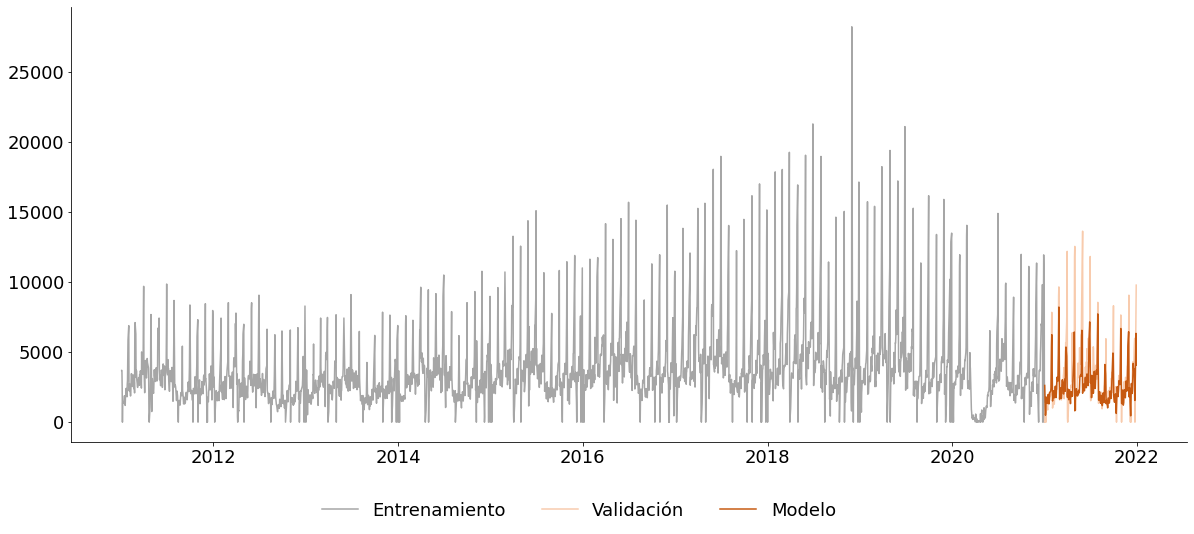

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_MUL_ADD, label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

#####**Mensualizar**

In [ ]:
# RMSE - 1 año
rms_HW_ADD_ADD_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_ADD_ADD.resample('M').apply(sum)))
rms_HW_MUL_MUL_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_MUL_MUL.resample('M').apply(sum)))
rms_HW_ADD_MUL_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_ADD_MUL.resample('M').apply(sum)))
rms_HW_MUL_ADD_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),forecast_HW_MUL_ADD.resample('M').apply(sum)))

print("ADD-ADD:", rms_HW_ADD_ADD_month_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_LT)

ADD-ADD: 18248.197083616225
MUL-MUL: 21537.726679635667
ADD-MUL: 19652.339831354413
MUL-ADD: 17134.987921286265


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_ADD_ADD.resample('M').apply(sum)[:3]))
rms_HW_MUL_MUL_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_MUL_MUL.resample('M').apply(sum)[:3]))
rms_HW_ADD_MUL_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_ADD_MUL.resample('M').apply(sum)[:3]))
rms_HW_MUL_ADD_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],forecast_HW_MUL_ADD.resample('M').apply(sum)[:3]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_MT)

ADD-ADD: 12881.252994267541
MUL-MUL: 29222.471677202902
ADD-MUL: 27318.802523202205
MUL-ADD: 12400.558247401757


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_ADD_ADD.resample('M').apply(sum)[:1]))
rms_HW_MUL_MUL_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_MUL_MUL.resample('M').apply(sum)[:1]))
rms_HW_ADD_MUL_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_ADD_MUL.resample('M').apply(sum)[:1]))
rms_HW_MUL_ADD_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],forecast_HW_MUL_ADD.resample('M').apply(sum)[:1]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_ST)
print("MUL-MUL:", rms_HW_MUL_MUL_month_ST)
print("ADD-MUL:", rms_HW_ADD_MUL_month_ST)
print("MUL-ADD:", rms_HW_MUL_ADD_month_ST)

ADD-ADD: 3999.7936123857144
MUL-MUL: 30136.894186152145
ADD-MUL: 28801.798076278006
MUL-ADD: 4765.791382246389


Entrenamiento: 2011-01-03 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-01 00:00:00  -  2021-12-29 00:00:00


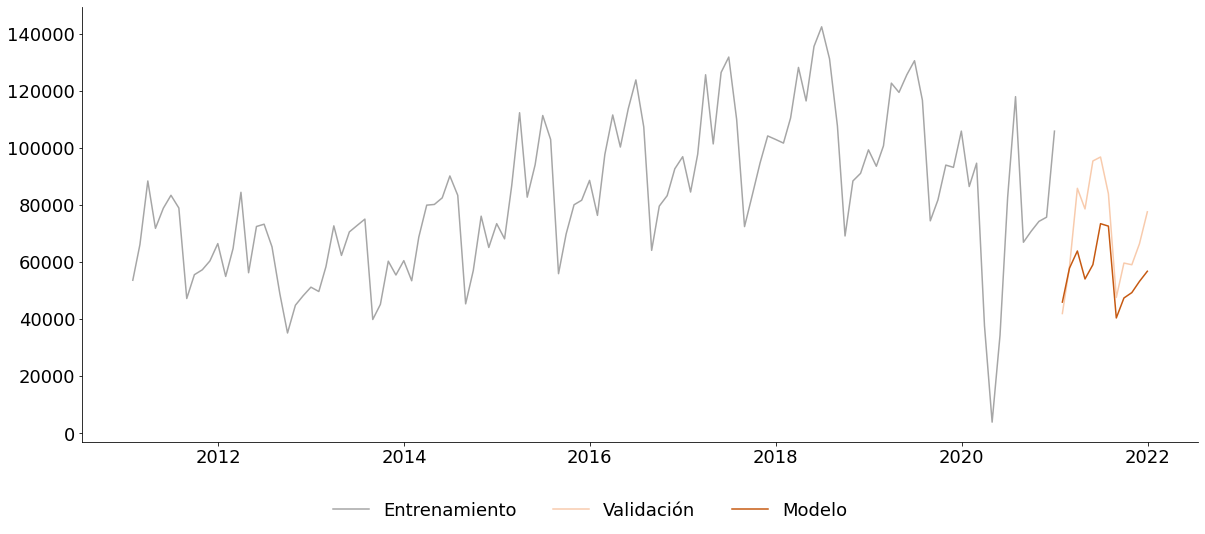

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_sinfindes.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_ADD_ADD.resample('M').apply(sum), label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-12)]
validacion = month_ts[int(len(month_ts)-12):]

In [ ]:
%time model_HWES3_ADD_ADD_mes = ExponentialSmoothing(entrenamiento,trend='add',seasonal='add',seasonal_periods=12, damped_trend = False).fit()

forecast_HW_ADD_ADD_mes = model_HWES3_ADD_ADD_mes.forecast(len(validacion))
forecast_HW_ADD_ADD_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_ADD_mes.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_ADD_mes = forecast_HW_ADD_ADD_mes.set_index('date_matric')

CPU times: user 119 ms, sys: 993 µs, total: 120 ms
Wall time: 121 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_MUL_mes = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='mul',seasonal_periods=12, damped_trend = False).fit()

forecast_HW_MUL_MUL_mes = model_HWES3_MUL_MUL_mes.forecast(len(validacion))
forecast_HW_MUL_MUL_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_MUL_mes.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_MUL_mes = forecast_HW_MUL_MUL_mes.set_index('date_matric')

CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 195 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_ADD_MUL_mes = ExponentialSmoothing(entrenamiento,trend='add',seasonal='mul',seasonal_periods=12, damped_trend = False).fit()

forecast_HW_ADD_MUL_mes = model_HWES3_ADD_MUL_mes.forecast(len(validacion))
forecast_HW_ADD_MUL_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_ADD_MUL_mes.values}) # para obtener fechas de las previsiones
forecast_HW_ADD_MUL_mes = forecast_HW_ADD_MUL_mes.set_index('date_matric')

CPU times: user 124 ms, sys: 990 µs, total: 125 ms
Wall time: 262 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
%time model_HWES3_MUL_ADD_mes = ExponentialSmoothing(entrenamiento,trend='mul',seasonal='ADD',seasonal_periods=12, damped_trend = True).fit()

forecast_HW_MUL_ADD_mes = model_HWES3_MUL_ADD_mes.forecast(len(validacion))
forecast_HW_MUL_ADD_mes = pd.DataFrame({'date_matric': validacion.index, 'prediccion': forecast_HW_MUL_ADD_mes.values}) # para obtener fechas de las previsiones
forecast_HW_MUL_ADD_mes = forecast_HW_MUL_ADD_mes.set_index('date_matric')

CPU times: user 506 ms, sys: 1.99 ms, total: 508 ms
Wall time: 529 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
# RMSE - 1 año
rms_HW_ADD_ADD_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_ADD_ADD_mes))
rms_HW_MUL_MUL_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_MUL_MUL_mes))
rms_HW_ADD_MUL_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_ADD_MUL_mes))
rms_HW_MUL_ADD_month_2_LT = sqrt(mean_squared_error(validacion,forecast_HW_MUL_ADD_mes))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_LT)

ADD-ADD: 35125.30142741288
MUL-MUL: 36238.804270636254
ADD-MUL: 37853.81839099526
MUL-ADD: 39794.77142179612


In [ ]:
# RMSE - 3 meses
rms_HW_ADD_ADD_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_ADD_ADD_mes[:3]))
rms_HW_MUL_MUL_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_MUL_MUL_mes[:3]))
rms_HW_ADD_MUL_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_ADD_MUL_mes[:3]))
rms_HW_MUL_ADD_month_2_MT = sqrt(mean_squared_error(validacion[:3],forecast_HW_MUL_ADD_mes[:3]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_MT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_MT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_MT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_MT)

ADD-ADD: 50110.30936208777
MUL-MUL: 53555.82501738502
ADD-MUL: 54358.714716132185
MUL-ADD: 51717.75432597332


In [ ]:
# RMSE - 1 mes
rms_HW_ADD_ADD_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_ADD_ADD_mes[:1]))
rms_HW_MUL_MUL_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_MUL_MUL_mes[:1]))
rms_HW_ADD_MUL_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_ADD_MUL_mes[:1]))
rms_HW_MUL_ADD_month_2_LT = sqrt(mean_squared_error(validacion[:1],forecast_HW_MUL_ADD_mes[:1]))

print("ADD-ADD:", rms_HW_ADD_ADD_month_2_LT)
print("MUL-MUL:", rms_HW_MUL_MUL_month_2_LT)
print("ADD-MUL:", rms_HW_ADD_MUL_month_2_LT)
print("MUL-ADD:", rms_HW_MUL_ADD_month_2_LT)

ADD-ADD: 56152.14224706043
MUL-MUL: 51576.87505394594
ADD-MUL: 51880.432917634345
MUL-ADD: 57004.051991600776


Entrenamiento: 2011-01-31 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-31 00:00:00  -  2021-12-31 00:00:00


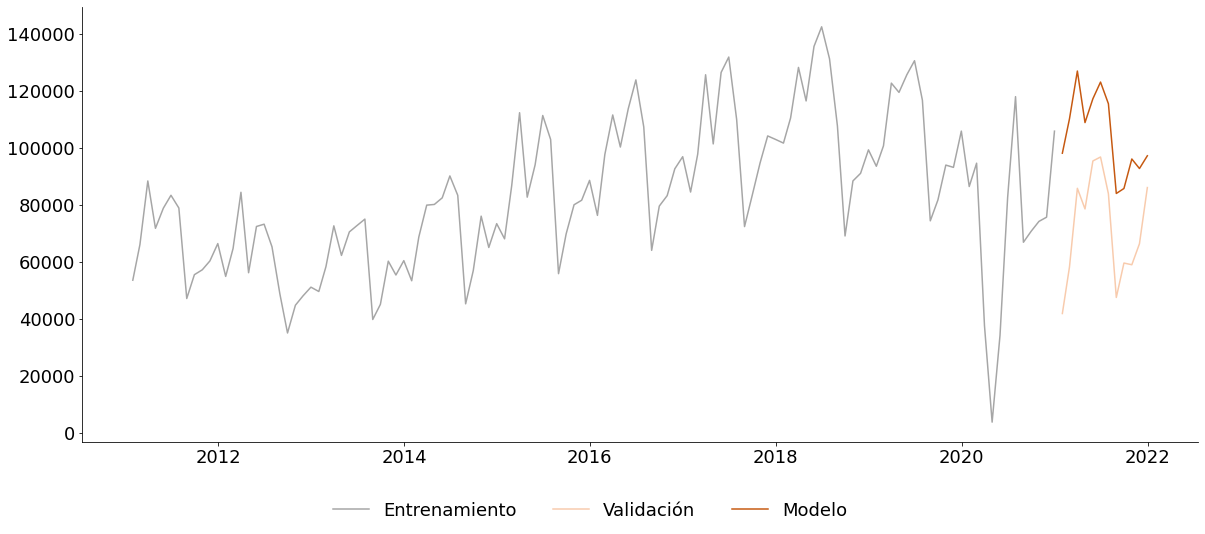

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_HW_ADD_ADD_mes, label="Modelo", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

### **<font color=21A5FF>TBATS</font>**

#####**Dato diario**

In [ ]:
# Completar datos con filas vacías (necesario para TBATS)
periodo_completo = pd.DataFrame({'date_matric': pd.date_range(start = data.index.min(),
                                                              end = data.index.max(),
                                                              freq='D')})

day_ts = periodo_completo.merge(data['total'], how='outer', on='date_matric')
day_ts['total'] = day_ts['total'].fillna(0)

day_ts = day_ts.set_index('date_matric')
day_ts.head()

,total
date_matric,
2011-01-03,3695.0
2011-01-04,3693.0
2011-01-05,2424.0
2011-01-06,0.0
2011-01-07,1394.0


In [ ]:
date_cut = '2021-01-01'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Entrenar el modelo
estimator = TBATS(seasonal_periods=[7, 30, 365.25])

%time smodel = estimator.fit(entrenamiento)

print('\n' + smodel.summary())

CPU times: user 1min 9s, sys: 1.85 s, total: 1min 11s
Wall time: 22min 40s

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.    30.   365.25]
Seasonal harmonics [3 6 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.069968
Seasonal Parameters (Gamma): [-0.00286361 -0.01216785  0.02333234 -0.01927338 -0.01033832  0.02341053]
AR coefficients []
MA coefficients []
Seed vector [1554.16047683 -929.72291706 1130.65227326  121.38848774 1883.27308223
  528.95439349 -481.45592901  166.58269727   64.19485097  -18.28944173
  -13.1116289    23.46366514  -43.08817392  100.55884957   -6.43414665
  -18.11865602    7.00769545  -44.12950594   10.61950134 -147.02310223
  461.11514006]

AIC 85567.031647


In [ ]:
# Predicción
tbats_forecast_day = smodel.forecast(steps=len(validacion))
tbats_forecast_day = pd.DataFrame(tbats_forecast_day,index = validacion.index,columns=['Prediction']) # Para obtener fechas de las previsiones
tbats_forecast_day = tbats_forecast_day[tbats_forecast_day.index.dayofweek < 5] # Eliminar los fines de semana

# Análisis
#print(smodel.y_hat) # in sample prediction
#print(smodel.resid) # in sample residuals
#print(smodel.aic)

# Leer parámetros del modelo
#print(smodel.params.alpha)
#print(smodel.params.beta)
#print(smodel.params.x0)
#print(smodel.params.components.use_box_cox)
#print(smodel.params.components.seasonal_harmonics)

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-01 00:00:00  -  2021-12-29 00:00:00


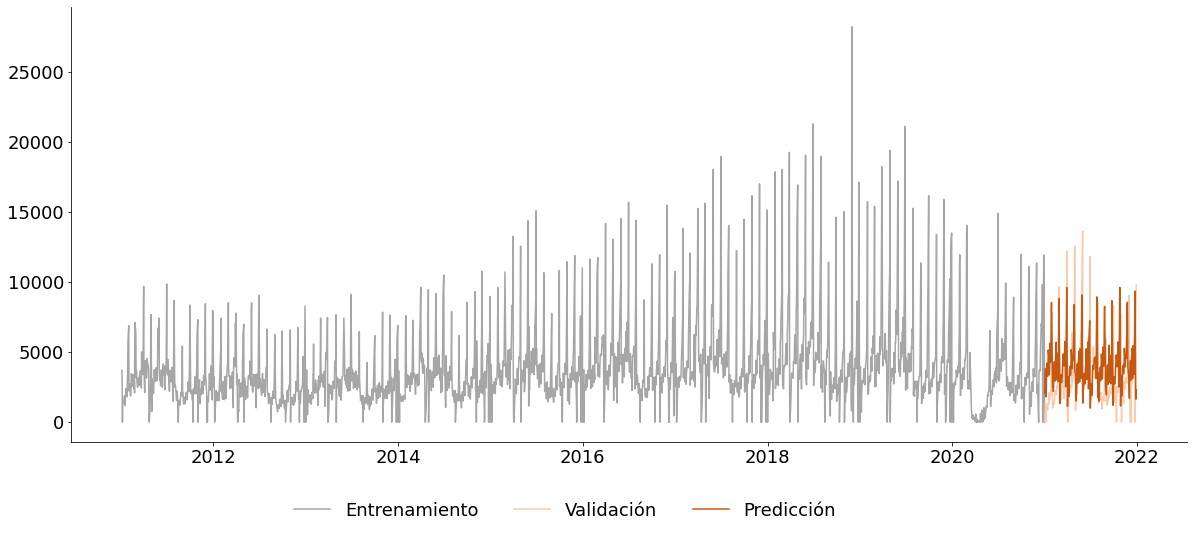

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(tbats_forecast_day, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_tbats_day_LT = sqrt(mean_squared_error(validacion_sinfindes,tbats_forecast_day))
print(rms_tbats_day_LT)

# RMSE - 3 meses
rms_tbats_day_MT = sqrt(mean_squared_error(validacion_sinfindes[:66],tbats_forecast_day[:66]))
print(rms_tbats_day_MT)

# RMSE - 1 mes
rms_tbats_day_ST = sqrt(mean_squared_error(validacion_sinfindes[:22],tbats_forecast_day[:22]))
print(rms_tbats_day_ST)

2721.283459922046
2334.9469100031592
2546.4321955100936


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-01 00:00:00  -  2021-12-29 00:00:00


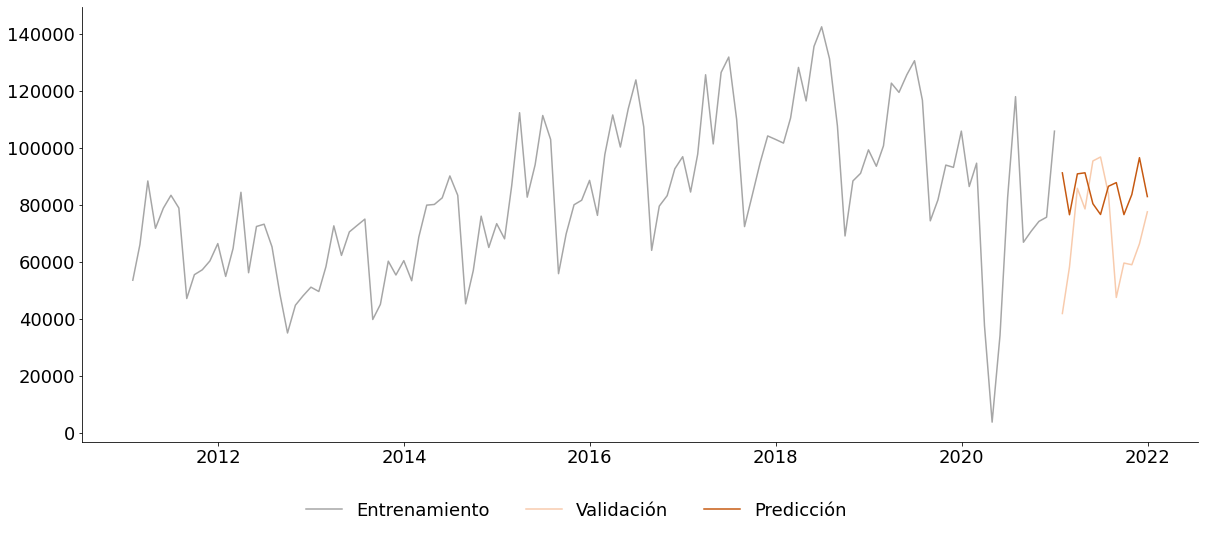

In [ ]:
rcParams['figure.figsize'] = 20, 8

entrenamiento_sinfindes = entrenamiento[entrenamiento.index.dayofweek < 5] # Eliminar los fines de semana
validacion_sinfindes = validacion[validacion.index.dayofweek < 5] # Eliminar los fines de semana

plt.plot(entrenamiento_sinfindes.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_sinfindes.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(tbats_forecast_day.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_tbats_month_LT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum),tbats_forecast_day.resample('M').apply(sum)))
print(rms_tbats_month_LT)

# RMSE - 3 meses
rms_tbats_month_MT = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:3],tbats_forecast_day.resample('M').apply(sum)[:3]))
print(rms_tbats_month_MT)

# RMSE - 1 mes
rms_tbats_month_ST = sqrt(mean_squared_error(validacion_sinfindes.resample('M').apply(sum)[:1],tbats_forecast_day.resample('M').apply(sum)[:1]))
print(rms_tbats_month_ST)

24208.688213392295
30477.92988590751
49261.554795582415


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-12)]
validacion = month_ts[int(len(month_ts)-12):]

In [ ]:
# Entrenar el modelo
estimator = TBATS(seasonal_periods=[12], use_trend=True, use_damped_trend=False)

%time smodel = estimator.fit(entrenamiento)

print('\n' + smodel.summary())

CPU times: user 1.36 s, sys: 171 ms, total: 1.53 s
Wall time: 36 s

Use Box-Cox: False
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.979293
Trend (Beta): -0.009795
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [ 8.82068239e-10 -1.72543742e-07]
AR coefficients []
MA coefficients []
Seed vector [73509.75560522   108.55448318 -3061.71111978  2951.18838809
 -7086.25906907 -1448.07488813 -3797.12227538 10636.30796272
 -7656.57076614  6084.3268071  -4887.34115415 -2853.40073433]

AIC 2861.684072


In [ ]:
# Predicción
tbats_forecast_month_2 = smodel.forecast(steps=len(validacion))
tbats_forecast_month_2 = pd.DataFrame(tbats_forecast_month_2,index = validacion.index,columns=['Prediction']) # Para obtener fechas de las previsiones

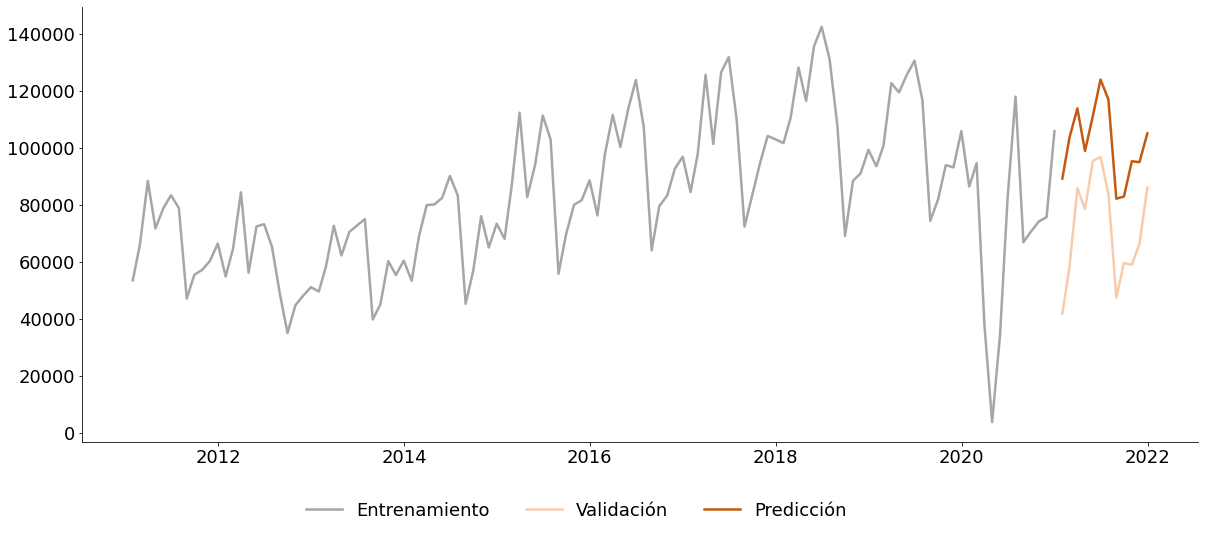

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(tbats_forecast_month_2, label="Predicción", color="#C65911", linewidth=2.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_tbats_month_2_LT = sqrt(mean_squared_error(validacion,tbats_forecast_month_2))
print(rms_tbats_month_2_LT)

# RMSE - 3 meses
rms_tbats_month_2_MT = sqrt(mean_squared_error(validacion[:3],tbats_forecast_month_2[:3]))
print(rms_tbats_month_2_MT)

# RMSE - 1 mes
rms_tbats_month_2_ST = sqrt(mean_squared_error(validacion[:1],tbats_forecast_month_2[:1]))
print(rms_tbats_month_2_ST)

31347.348019616922
41113.27936259953
47270.071331401356


###**<font color=21A5FF>PROPHET</font>**

#####**Dato diario**

Para aplicar este algoritmo, los datos deben tener una estructura en concreto.

La columna de fecha debe llamarse `ds` y la que contiene los datos `y`.

In [ ]:
day_ts = data.reset_index()[['date_matric', 'total']]
day_ts['ds'] = day_ts['date_matric']
day_ts['y'] = day_ts['total']
day_ts.set_index('date_matric');

In [ ]:
# Dividir entrenamiento y test
entrenamiento = day_ts[day_ts['date_matric']<='2020-12-31']
validacion = day_ts[day_ts['date_matric']>'2020-12-31']

In [ ]:
# Aplicar transformación Box-Cox 
entrenamiento['y'], lam = boxcox(entrenamiento['total']) 
entrenamiento.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date_matric,total,ds,y
0,2011-01-03,3695.0,2011-01-03,20.452736
1,2011-01-04,3693.0,2011-01-04,20.450021
2,2011-01-05,2424.0,2011-01-05,18.424043
3,2011-01-07,1394.0,2011-01-07,16.004043
4,2011-01-10,1373.0,2011-01-10,15.941279


Generar dataset al que poder añadir aquellos festivos que queramos definir.

In [ ]:
festivos = pd.DataFrame({
  'holiday': 'dia_festivo',
  'ds': pd.to_datetime([]),
  'lower_window': 0,
  'upper_window': 0,
})

In [ ]:
m = Prophet(seasonality_mode = 'additive', 
            yearly_seasonality=True,
            weekly_seasonality=True,
            holidays = festivos
            )

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.add_country_holidays(country_name='ES') # Añadir los festivos nacionales que hay en España

entrenamiento = entrenamiento[entrenamiento['ds'].dt.dayofweek < 5] # Eliminar los fines de semana

In [ ]:
# Entrenar el modelo
%time m.fit(entrenamiento)
m.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2 s, sys: 29.2 ms, total: 2.03 s
Wall time: 2.03 s


0                                        Año nuevo
1                               Epifanía del Señor
2                  Día del Trabajador (Trasladado)
3                            Asunción de la Virgen
4                             Día de la Hispanidad
5                                 Todos los Santos
6                  Día de la Constitución Española
7                         La Inmaculada Concepción
8                             Navidad (Trasladado)
9                           Año nuevo (Trasladado)
10                              Día del Trabajador
11                                         Navidad
12                 Epifanía del Señor (Trasladado)
13           La Inmaculada Concepción (Trasladado)
14                   Todos los Santos (Trasladado)
15    Día de la Constitución Española (Trasladado)
16               Día de la Hispanidad (Trasladado)
dtype: object

In [ ]:
# Definir el periodo a predecir
rango = pd.DataFrame(pd.date_range(start=entrenamiento['date_matric'].max(),
                                   end=validacion['date_matric'].max(),
                                   freq='D'))

future = m.make_future_dataframe(periods=len(rango))
future = future[future['ds'].dt.dayofweek < 5] # Eliminar los fines de semana en los valores a predecir
future = future[future['ds'].isin(day_ts['date_matric'])] # Eliminar los días en los que no hubo matriculación en la validación o el entrenamiento

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2760,2021-12-23,19.917132,17.036337,22.940152
2761,2021-12-27,18.958551,16.093638,21.979247
2762,2021-12-28,20.014859,17.137796,22.956455
2763,2021-12-29,21.013595,17.938123,23.989267
2764,2021-12-30,21.557377,18.262263,24.722251


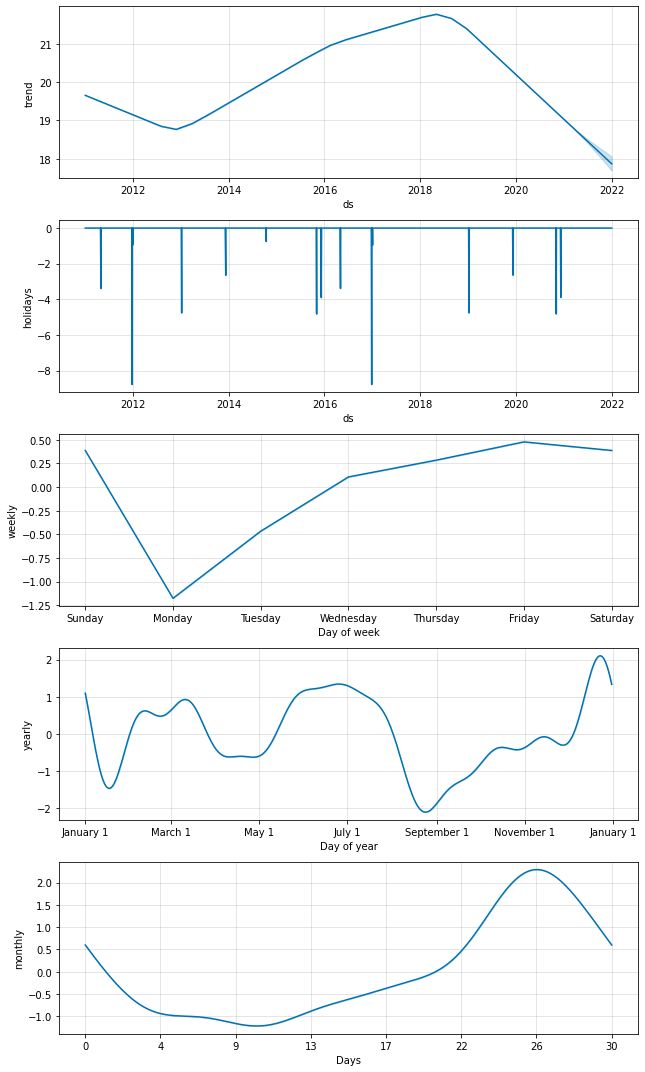

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# Invertir transformación Box-Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [ ]:
prediccion = forecast[forecast['ds']>=min(validacion['ds'])] # eliminar el entrenamiento de la predicción

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
prediccion = prediccion.set_index('ds')

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-30 00:00:00


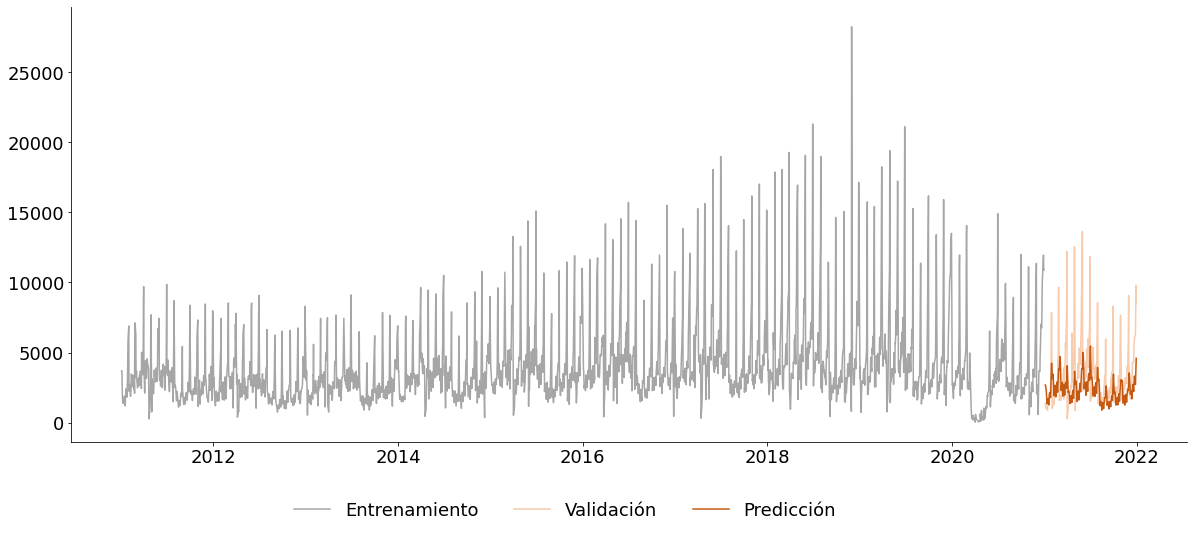

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(prediccion['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_prophet_day_LT = sqrt(mean_squared_error(validacion['total'],prediccion['yhat']))
print(rms_prophet_day_LT)

# RMSE - 3 meses
rms_prophet_day_MT = sqrt(mean_squared_error(validacion['total'][:66],prediccion['yhat'][:66]))
print(rms_prophet_day_MT)

# RMSE - 1 mes
rms_prophet_day_ST = sqrt(mean_squared_error(validacion['total'][:22],prediccion['yhat'][:22]))
print(rms_prophet_day_ST)

2323.1851051520366
2239.906276310221
1421.6513549661588


#####**Mensualizar**

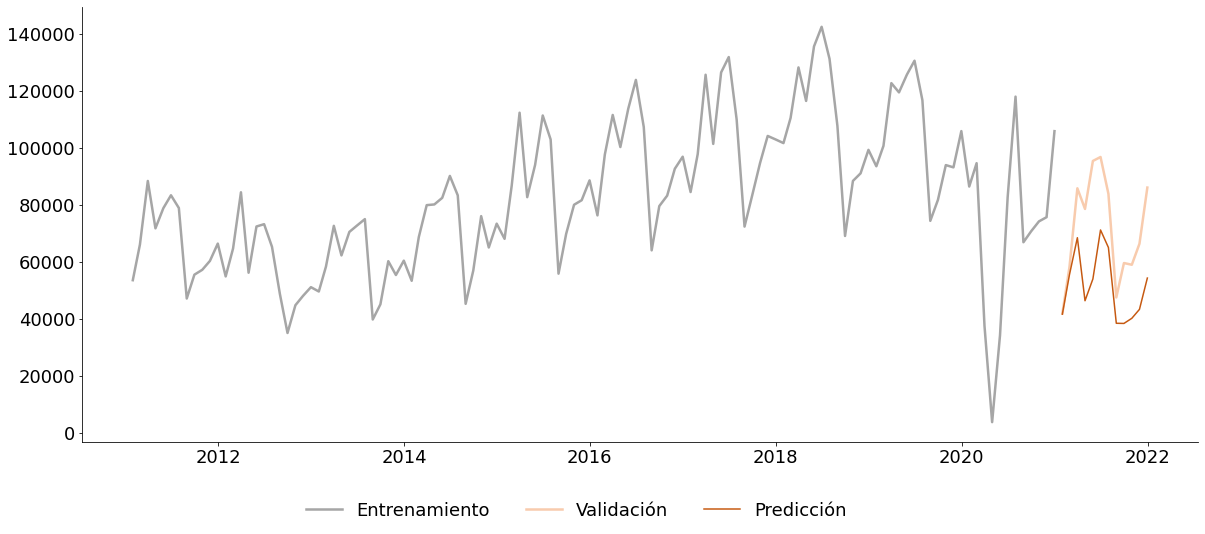

In [ ]:
month_forecast = prediccion.resample('M').apply(sum)
month_ts = day_ts.resample('M', on='ds').apply(sum)
entrenamiento_month = month_ts[:int(len(month_ts)-12)]
validacion_month = month_ts[int(len(month_ts)-12):]

rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_month['total'], label="Entrenamiento", color="#A6A6A6", linewidth=2.5)
plt.plot(validacion_month['total'], label="Validación", color="#F8CBAD", linewidth=2.5)
plt.plot(month_forecast['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_prophet_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total,month_forecast['yhat']))
print(rms_prophet_month_LT)

# RMSE - 3 meses
rms_prophet_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total[:3],month_forecast['yhat'][:3]))
print(rms_prophet_month_MT)

# RMSE - 1 mes
rms_prophet_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum).total[:1],month_forecast['yhat'][:1]))
print(rms_prophet_month_ST)

23219.18936146057
10108.64455061056
230.77091718323936


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
month_ts = month_ts.reset_index()[['date_matric', 'total']]
month_ts['ds'] = month_ts['date_matric']
month_ts['y'] = month_ts['total']
month_ts.set_index('date_matric');

In [ ]:
# Dividir entrenamiento y test
entrenamiento = month_ts[:int(len(month_ts)-12)]
validacion = month_ts[int(len(month_ts)-12):]

In [ ]:
validacion.count()

date_matric    12
total          12
ds             12
y              12
dtype: int64

In [ ]:
# Aplicar transformación Box-Cox 
entrenamiento['y'], lam = boxcox(entrenamiento['total']) 
entrenamiento.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date_matric,total,ds,y
0,2011-01-31,53633.0,2011-01-31,39018.887534
1,2011-02-28,66116.0,2011-02-28,47777.539194
2,2011-03-31,88394.0,2011-03-31,63281.857752
3,2011-04-30,71803.0,2011-04-30,51749.480158
4,2011-05-31,78855.0,2011-05-31,56660.785564


In [ ]:
m = Prophet(seasonality_mode = 'additive')

In [ ]:
# Entrenar el modelo
%time m.fit(entrenamiento)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 78.6 ms, sys: 3.27 ms, total: 81.9 ms
Wall time: 87.4 ms


In [ ]:
# Definir el periodo a predecir
future = m.make_future_dataframe(periods=12, freq = 'M')

In [ ]:
forecast = m.predict(future)
forecast = forecast[int(len(forecast)-12):]

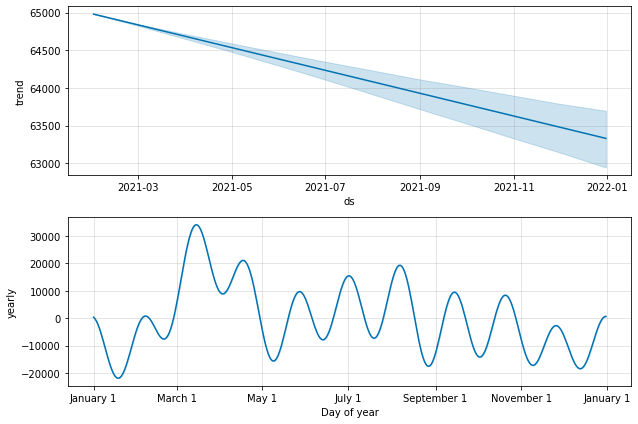

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# Invertir transformación Box-Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast = forecast.set_index('ds');

Entrenamiento: 2011-01-31 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-31 00:00:00  -  2021-12-31 00:00:00


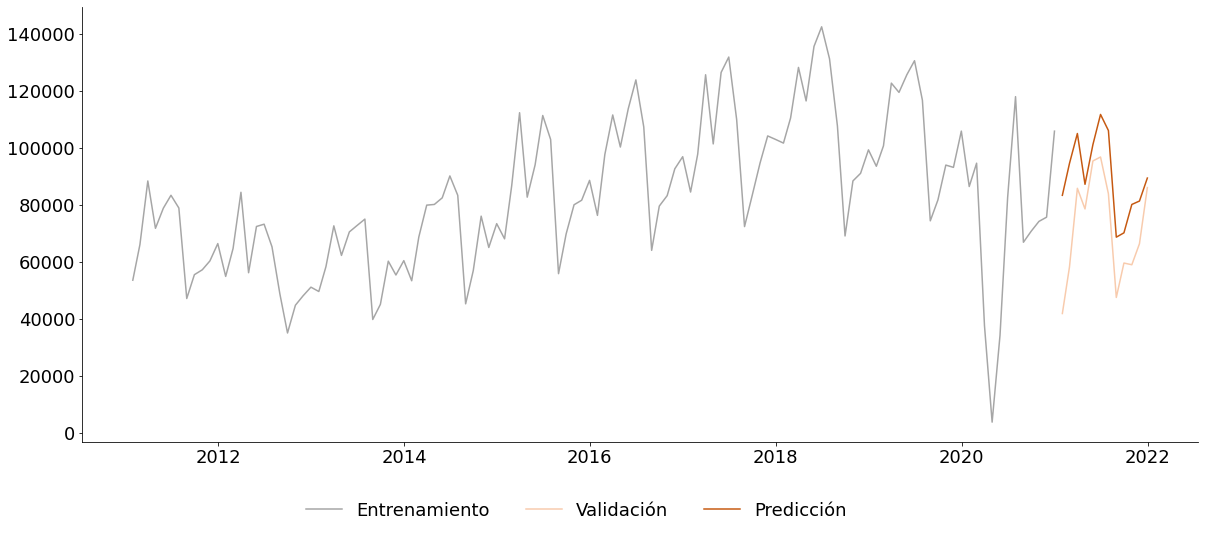

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast['yhat'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_prophet_month_2_LT = sqrt(mean_squared_error(validacion['total'],forecast['yhat']))
print(rms_prophet_month_2_LT)

# RMSE - 3 meses
rms_prophet_month_2_MT = sqrt(mean_squared_error(validacion['total'][:3],forecast['yhat'][:3]))
print(rms_prophet_month_2_MT)

# RMSE - 1 mes
rms_prophet_month_2_ST = sqrt(mean_squared_error(validacion['total'][:1],forecast['yhat'][:1]))
print(rms_prophet_month_2_ST)

21323.909603649397
33651.26315009847
41403.011406055084


###**<font color=21A5FF>XGBoost</font>**


##### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2020-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

In [ ]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_matric  2513 non-null   datetime64[ns]
 1   total        2513 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['dayofweek'] = df['date_matric'].dt.dayofweek
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    df['dayofyear'] = df['date_matric'].dt.dayofyear
    df['dayofmonth'] = df['date_matric'].dt.day
    df['weekofyear'] = df['date_matric'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(entrenamiento, label='total')
X_test, y_test = create_features(validacion, label='total')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 270 ms, sys: 20 ms, total: 290 ms
Wall time: 393 ms


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


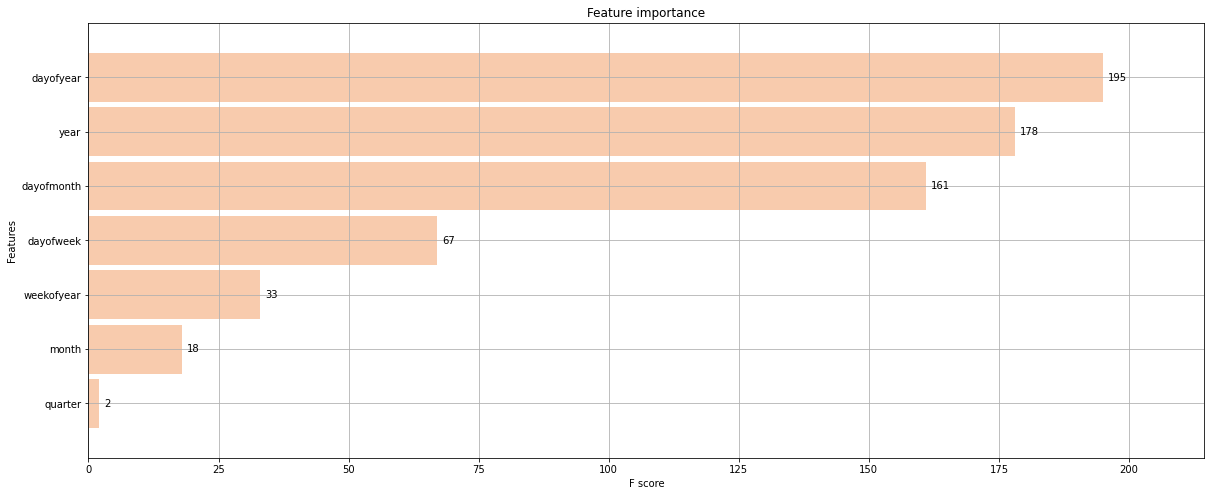

In [ ]:
plot_importance(model, height=0.9, color="#F8CBAD")

In [ ]:
forecast_XGB = model.predict(X_test)
forecast_XGB = pd.DataFrame({'date_matric': validacion['date_matric'], 'prediccion': forecast_XGB}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast_XGB = forecast_XGB.set_index('date_matric')

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


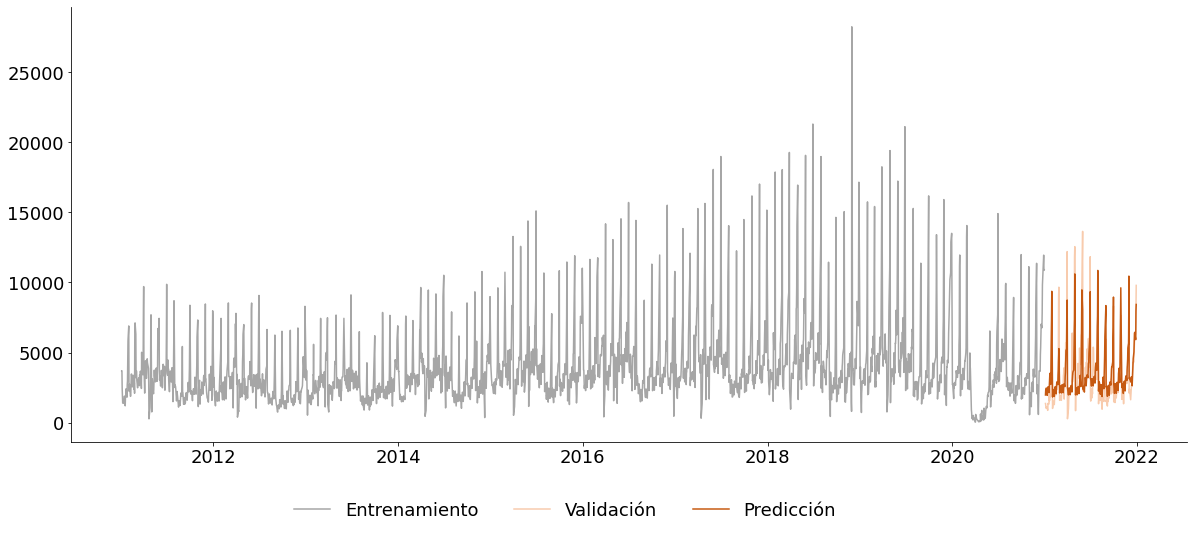

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_XGB_day_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB['prediccion']))
print(rms_XGB_day_LT)

# RMSE - 3 meses
rms_XGB_day_MT = sqrt(mean_squared_error(validacion['total'][:66],forecast_XGB['prediccion'][:66]))
print(rms_XGB_day_MT)

# RMSE - 1 mes
rms_XGB_day_ST = sqrt(mean_squared_error(validacion['total'][:22],forecast_XGB['prediccion'][:22]))
print(rms_XGB_day_ST)

1216.9634275313585
1310.5076481930562
1233.2183558609152


#####**Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


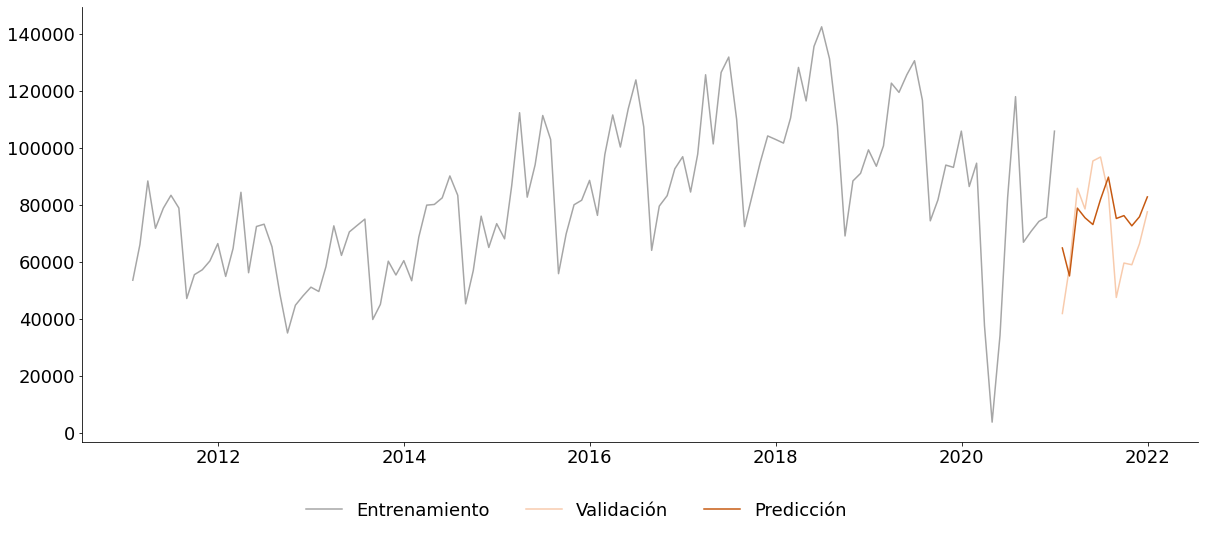

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'].resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'].resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'].resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_XGB_month_LT = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum),forecast_XGB['prediccion'].resample('M').apply(sum)))
print(rms_XGB_month_LT)

# RMSE - 3 meses
rms_XGB_month_MT = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum)[:3],forecast_XGB['prediccion'].resample('M').apply(sum)[:3]))
print(rms_XGB_month_MT)

# RMSE - 1 mes
rms_XGB_month_ST = sqrt(mean_squared_error(validacion['total'].resample('M').apply(sum)[:1],forecast_XGB['prediccion'].resample('M').apply(sum)[:1]))
print(rms_XGB_month_ST)

14970.72376115044
13967.76430001001
22962.390625


#####**Mensual**

In [ ]:
month_ts = data['total'].resample('M').apply(sum)

In [ ]:
entrenamiento = month_ts[:int(len(month_ts)-12)]
validacion = month_ts[int(len(month_ts)-12):]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    
    X = df[['quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(entrenamiento, label='total')
X_test, y_test = create_features(validacion, label='total')

In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 137 ms, sys: 2.07 ms, total: 139 ms
Wall time: 142 ms


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


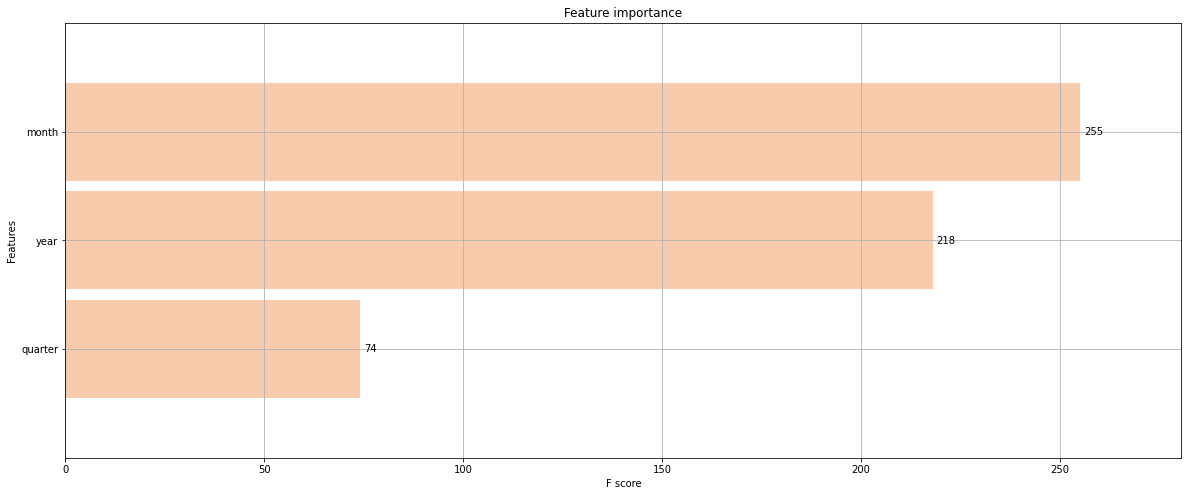

In [ ]:
plot_importance(model, height=0.9, color="#F8CBAD")

In [ ]:
forecast_XGB = model.predict(X_test)
forecast_XGB = pd.DataFrame({'date_matric': validacion['date_matric'], 'prediccion': forecast_XGB}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')
forecast_XGB = forecast_XGB.set_index('date_matric')

Entrenamiento: 2011-01-31 00:00:00  -  2020-12-31 00:00:00
Validación:  2021-01-31 00:00:00  -  2021-12-31 00:00:00


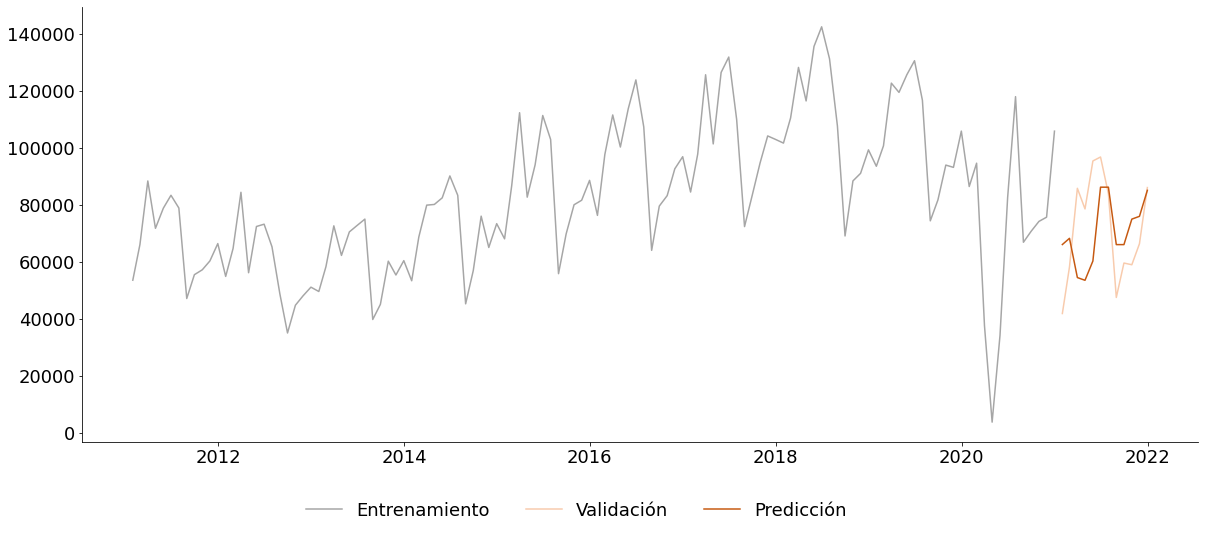

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
rms_XGB_month_2_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB['prediccion']))
print(rms_XGB_month_2_LT)

# RMSE - 3 meses
rms_XGB_month_2_MT = sqrt(mean_squared_error(validacion['total'][:3],forecast_XGB['prediccion'][:3]))
print(rms_XGB_month_2_MT)

# RMSE - 1 mes
rms_XGB_month_2_ST = sqrt(mean_squared_error(validacion['total'][:1],forecast_XGB['prediccion'][:1]))
print(rms_XGB_month_2_ST)

19071.93784131071
23534.899888253658
24160.6953125


###**<font color=21A5FF>Red Neuronal Recurrente (RNR)</font>**

##### **Para replicar los resultados**

In [ ]:
#Para replicar resultados
# Set a seed value
seed_value= 7 

# Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

##### **Long Short-Term Memory (LSTM)**

###### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2020-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Ajustar el scaler sobre el conjunto de entrenamiento
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler_fit = min_max_scaler.fit(entrenamiento.values.reshape(-1, 1))

# Aplicar el scaler a los conjuntos de entrenamiento y validación
entrenamiento = min_max_scaler.transform(entrenamiento.values.reshape(-1, 1))
#validacion = min_max_scaler.transform(validacion.values.reshape(-1, 1))

In [ ]:
X_train = []
y_train = []
for i in range(60,len(entrenamiento)):
    X_train.append(entrenamiento[i-60:i,0])
    y_train.append(entrenamiento[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

En Python la red LSTM espera recibir los datos de una forma específica:

`[samples, time steps, features]`

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Crear LSTM
model = Sequential()

# Primer capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2, seed=7))
# Segunda capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2, seed=7))
# Tercera capa con proceso de regularización de abandono
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2, seed=7))
# Cuarta capa con proceso de regularización de abandono
model.add(LSTM(units=20))
model.add(Dropout(0.2, seed=7))
# Capa de salida
model.add(Dense(units=1))

# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting to the training set
%time model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
2453/2453 - 129s - loss: 0.0094 - 129s/epoch - 53ms/step
Epoch 2/20
2453/2453 - 122s - loss: 0.0081 - 122s/epoch - 50ms/step
Epoch 3/20
2453/2453 - 120s - loss: 0.0075 - 120s/epoch - 49ms/step
Epoch 4/20
2453/2453 - 119s - loss: 0.0072 - 119s/epoch - 49ms/step
Epoch 5/20
2453/2453 - 120s - loss: 0.0065 - 120s/epoch - 49ms/step
Epoch 6/20
2453/2453 - 121s - loss: 0.0064 - 121s/epoch - 49ms/step
Epoch 7/20
2453/2453 - 120s - loss: 0.0061 - 120s/epoch - 49ms/step
Epoch 8/20
2453/2453 - 133s - loss: 0.0059 - 133s/epoch - 54ms/step
Epoch 9/20
2453/2453 - 119s - loss: 0.0053 - 119s/epoch - 49ms/step
Epoch 10/20
2453/2453 - 119s - loss: 0.0060 - 119s/epoch - 49ms/step
Epoch 11/20
2453/2453 - 118s - loss: 0.0051 - 118s/epoch - 48ms/step
Epoch 12/20
2453/2453 - 120s - loss: 0.0050 - 120s/epoch - 49ms/step
Epoch 13/20
2453/2453 - 121s - loss: 0.0045 - 121s/epoch - 49ms/step
Epoch 14/20
2453/2453 - 121s - loss: 0.0046 - 121s/epoch - 49ms/step
Epoch 15/20
2453/2453 - 118s - loss: 0.0045

In [ ]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 60, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            3280      
                                                                 
 dropout_1 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 20)            3280      
                                                                 
 dropout_2 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                3

In [ ]:
inputs = day_ts[len(day_ts)-len(validacion) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = min_max_scaler.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_LSTM_forecast = model.predict(X_test)
y_LSTM_forecast = min_max_scaler.inverse_transform(y_LSTM_forecast)

In [ ]:
LSTM_forecast = pd.DataFrame(y_LSTM_forecast, index = validacion.index) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = day_ts.iloc[start_en:end_en]

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


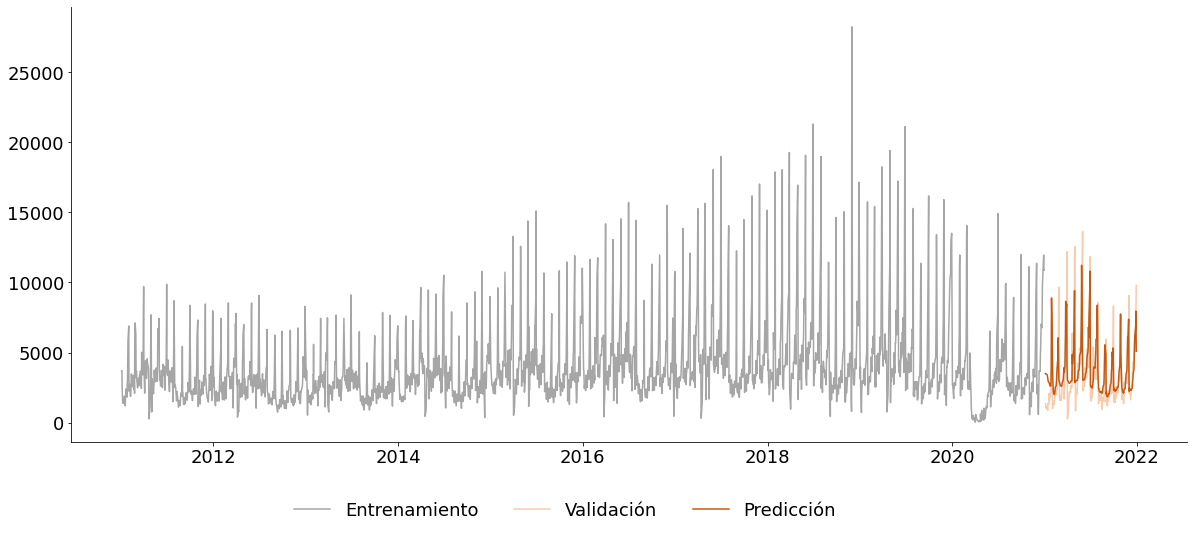

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(LSTM_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
LSTM_day_LT = sqrt(mean_squared_error(validacion,LSTM_forecast))
print(LSTM_day_LT)

# RMSE - 3 meses
LSTM_day_MT = sqrt(mean_squared_error(validacion[:66],LSTM_forecast[:66]))
print(LSTM_day_MT)

# RMSE - 1 mes
LSTM_day_ST = sqrt(mean_squared_error(validacion[:22],LSTM_forecast[:22]))
print(LSTM_day_ST)

1813.3262878439325
2118.8203348195216
1766.3285761772675


###### **Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


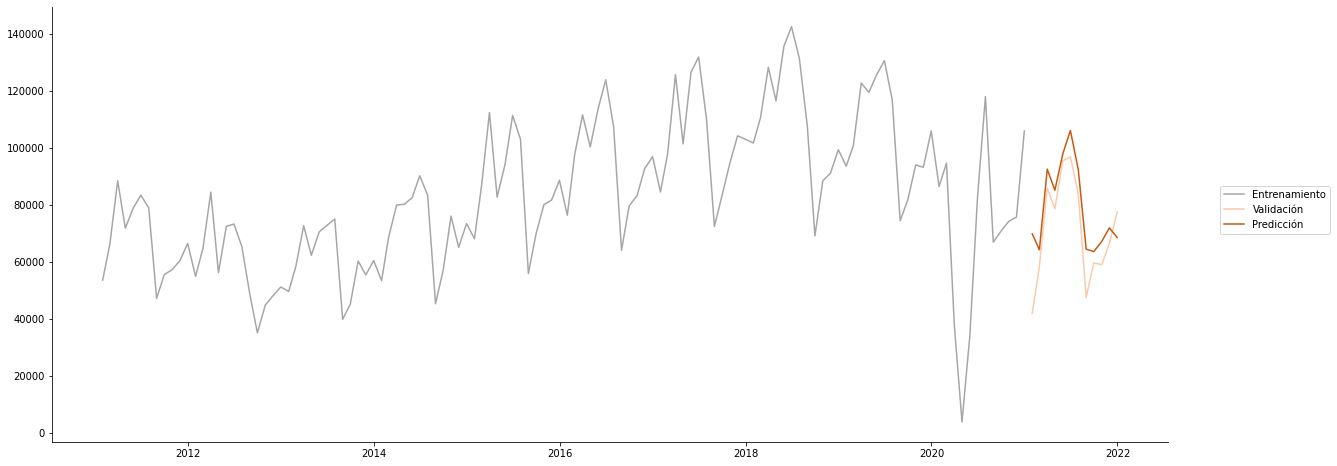

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(LSTM_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(1.15, 0.6))

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
LSTM_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),LSTM_forecast.resample('M').apply(sum)))
print(LSTM_month_LT)

# RMSE - 3 meses
LSTM_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],LSTM_forecast.resample('M').apply(sum)[:3]))
print(LSTM_month_MT)

# RMSE - 1 mes
LSTM_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],LSTM_forecast.resample('M').apply(sum)[:1]))
print(LSTM_month_ST)

11336.747179407372
16918.140073416667
27899.359375


##### **Gated Recurrent Units (GRU)**

###### **Datos diarios**

In [ ]:
day_ts = data['total']

In [ ]:
date_cut = '2020-12-31'
start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))
entrenamiento = day_ts.iloc[start_en:end_en]
start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))
validacion = day_ts.iloc[start_va:end_va]

In [ ]:
# Ajustar el scaler sobre el conjunto de entrenamiento
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler_fit = min_max_scaler.fit(entrenamiento.values.reshape(-1, 1))

# Aplicar el scaler a los conjuntos de entrenamiento y validación
entrenamiento = min_max_scaler.transform(entrenamiento.values.reshape(-1, 1))
#validacion = min_max_scaler.transform(validacion.values.reshape(-1, 1))

In [ ]:
X_train = []
y_train = []
for i in range(60,len(entrenamiento)):
    X_train.append(entrenamiento[i-60:i,0])
    y_train.append(entrenamiento[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

En Python la red LSTM espera recibir los datos de una forma específica:

`[samples, time steps, features]`

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Crear GRU
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(units=20, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=20, return_sequences=True))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=20, return_sequences=True))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=20))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting to the training set
%time model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
2453/2453 - 116s - loss: 0.0094 - 116s/epoch - 47ms/step
Epoch 2/20
2453/2453 - 111s - loss: 0.0073 - 111s/epoch - 45ms/step
Epoch 3/20
2453/2453 - 109s - loss: 0.0069 - 109s/epoch - 44ms/step
Epoch 4/20
2453/2453 - 108s - loss: 0.0067 - 108s/epoch - 44ms/step
Epoch 5/20
2453/2453 - 108s - loss: 0.0063 - 108s/epoch - 44ms/step
Epoch 6/20
2453/2453 - 112s - loss: 0.0062 - 112s/epoch - 46ms/step
Epoch 7/20
2453/2453 - 113s - loss: 0.0061 - 113s/epoch - 46ms/step
Epoch 8/20
2453/2453 - 112s - loss: 0.0056 - 112s/epoch - 46ms/step
Epoch 9/20
2453/2453 - 108s - loss: 0.0056 - 108s/epoch - 44ms/step
Epoch 10/20
2453/2453 - 112s - loss: 0.0052 - 112s/epoch - 45ms/step
Epoch 11/20
2453/2453 - 112s - loss: 0.0051 - 112s/epoch - 46ms/step
Epoch 12/20
2453/2453 - 112s - loss: 0.0049 - 112s/epoch - 46ms/step
Epoch 13/20
2453/2453 - 114s - loss: 0.0047 - 114s/epoch - 46ms/step
Epoch 14/20
2453/2453 - 109s - loss: 0.0047 - 109s/epoch - 44ms/step
Epoch 15/20
2453/2453 - 110s - loss: 0.0046

In [ ]:
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 20)            1380      
                                                                 
 dropout_4 (Dropout)         (None, 60, 20)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 20)            2520      
                                                                 
 dropout_5 (Dropout)         (None, 60, 20)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 20)            2520      
                                                                 
 dropout_6 (Dropout)         (None, 60, 20)            0         
                                                                 
 gru_3 (GRU)                 (None, 20)               

In [ ]:
inputs = day_ts[len(day_ts)-len(validacion) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = min_max_scaler.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_GRU_forecast = model.predict(X_test)
y_GRU_forecast = min_max_scaler.inverse_transform(y_GRU_forecast)

In [ ]:
GRU_forecast = pd.DataFrame(y_GRU_forecast, index = validacion.index) # para obtener fechas de las previsiones

In [ ]:
entrenamiento = day_ts.iloc[start_en:end_en]

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


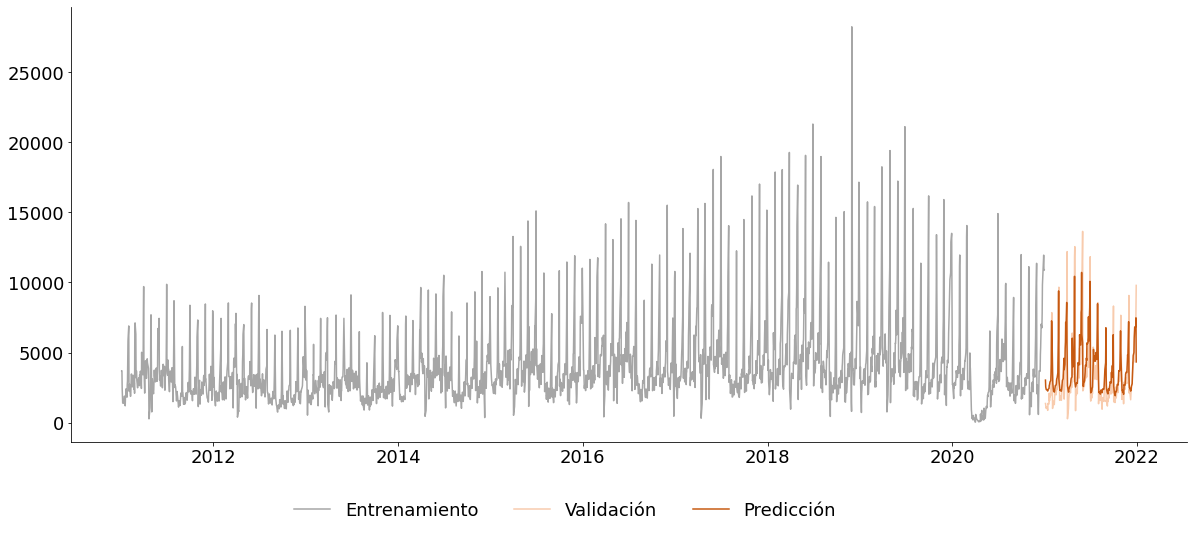

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento, label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion, label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(GRU_forecast, label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
GRU_day_LT = sqrt(mean_squared_error(validacion,GRU_forecast))
print(GRU_day_LT)

# RMSE - 3 meses
GRU_day_MT = sqrt(mean_squared_error(validacion[:66],GRU_forecast[:66]))
print(GRU_day_MT)

# RMSE - 1 mes
GRU_day_ST = sqrt(mean_squared_error(validacion[:22],GRU_forecast[:22]))
print(GRU_day_ST)

1484.0909886673087
1646.3965695933634
1240.2300081605113


###### **Mensualizar**

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


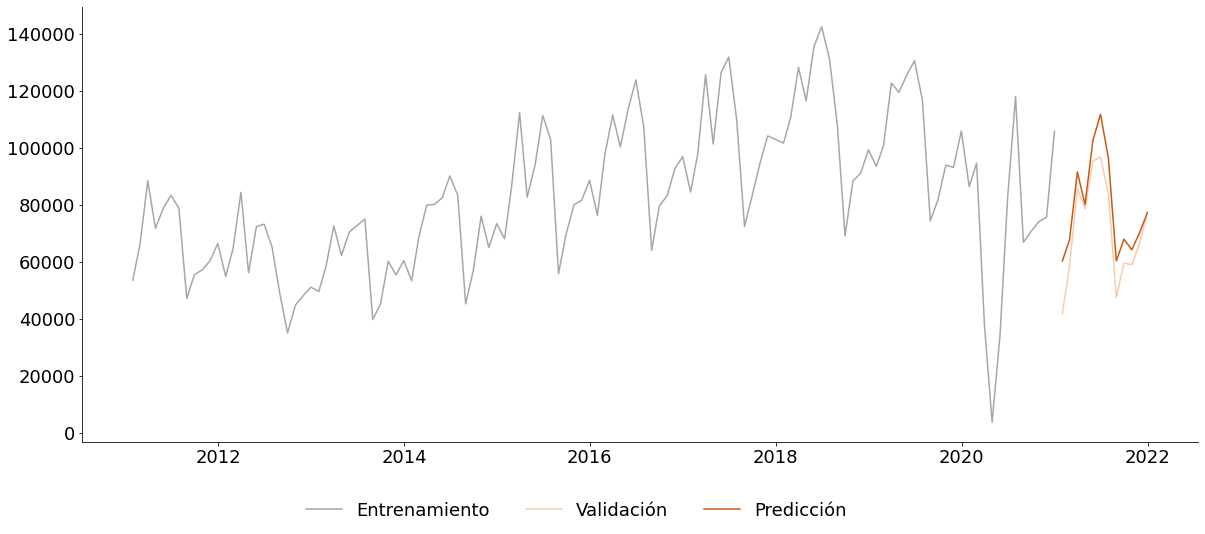

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento.resample('M').apply(sum), label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion.resample('M').apply(sum), label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(GRU_forecast.resample('M').apply(sum), label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 1 año
GRU_month_LT = sqrt(mean_squared_error(validacion.resample('M').apply(sum),GRU_forecast.resample('M').apply(sum)))
print(GRU_month_LT)

# RMSE - 3 meses
GRU_month_MT = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:3],GRU_forecast.resample('M').apply(sum)[:3]))
print(GRU_month_MT)

# RMSE - 1 mes
GRU_month_ST = sqrt(mean_squared_error(validacion.resample('M').apply(sum)[:1],GRU_forecast.resample('M').apply(sum)[:1]))
print(GRU_month_ST)

9865.291572949283
12379.657072110193
18396.07421875


##**<font color=FF6633>Extra: por canales**</font>

###**<font color=21A5FF>XGBoost</font>**


##### **Datos diarios**

In [ ]:
day_ts = data['total']

day_ts_alquilador = data['ALQUILADOR']
day_ts_empresa = data['EMPRESA']
day_ts_particular = data['PARTICULAR']

In [ ]:
date_cut = '2020-12-31'

start_en = day_ts.index.searchsorted(pd.to_datetime(min(day_ts.index)))
end_en = day_ts.index.searchsorted(pd.to_datetime(date_cut))

entrenamiento = day_ts.iloc[start_en:end_en]
entrenamiento_alquilador = day_ts_alquilador.iloc[start_en:end_en]
entrenamiento_empresa = day_ts_empresa.iloc[start_en:end_en]
entrenamiento_particular = day_ts_particular.iloc[start_en:end_en]


start_va = day_ts.index.searchsorted(pd.to_datetime(date_cut))
end_va = day_ts.index.searchsorted(pd.to_datetime(max(day_ts.index)))

validacion = day_ts.iloc[start_va:end_va]
validacion_alquilador = day_ts_alquilador.iloc[start_va:end_va]
validacion_empresa = day_ts_empresa.iloc[start_va:end_va]
validacion_particular = day_ts_particular.iloc[start_va:end_va]

In [ ]:
entrenamiento = pd.DataFrame({'date_matric': entrenamiento.index, 'total': entrenamiento.values}) 
validacion = pd.DataFrame({'date_matric': validacion.index, 'total': validacion.values}) 
entrenamiento['date_matric'] = pd.to_datetime(entrenamiento['date_matric'], format='%Y-%m-%d')
validacion['date_matric'] = pd.to_datetime(validacion['date_matric'], format='%Y-%m-%d')

entrenamiento_alquilador = pd.DataFrame({'date_matric': entrenamiento_alquilador.index, 'total': entrenamiento_alquilador.values}) 
validacion_alquilador = pd.DataFrame({'date_matric': validacion_alquilador.index, 'total': validacion_alquilador.values}) 
entrenamiento_alquilador['date_matric'] = pd.to_datetime(entrenamiento_alquilador['date_matric'], format='%Y-%m-%d')
validacion_alquilador['date_matric'] = pd.to_datetime(validacion_alquilador['date_matric'], format='%Y-%m-%d')

entrenamiento_empresa = pd.DataFrame({'date_matric': entrenamiento_empresa.index, 'total': entrenamiento_empresa.values}) 
validacion_empresa = pd.DataFrame({'date_matric': validacion_empresa.index, 'total': validacion_empresa.values}) 
entrenamiento_empresa['date_matric'] = pd.to_datetime(entrenamiento_empresa['date_matric'], format='%Y-%m-%d')
validacion_empresa['date_matric'] = pd.to_datetime(validacion_empresa['date_matric'], format='%Y-%m-%d')

entrenamiento_particular = pd.DataFrame({'date_matric': entrenamiento_particular.index, 'total': entrenamiento_particular.values}) 
validacion_particular = pd.DataFrame({'date_matric': validacion_particular.index, 'total': validacion_particular.values}) 
entrenamiento_particular['date_matric'] = pd.to_datetime(entrenamiento_particular['date_matric'], format='%Y-%m-%d')
validacion_particular['date_matric'] = pd.to_datetime(validacion_particular['date_matric'], format='%Y-%m-%d')

In [ ]:
def create_features(df, label=None):
    """
    Crear atributos de la serie temporal en base al índice
    """
    df['date_matric'] = pd.to_datetime(df['date_matric'], format='%Y-%m-%d')
    df['dayofweek'] = df['date_matric'].dt.dayofweek
    df['quarter'] = df['date_matric'].dt.quarter
    df['month'] = df['date_matric'].dt.month
    df['year'] = df['date_matric'].dt.year
    df['dayofyear'] = df['date_matric'].dt.dayofyear
    df['dayofmonth'] = df['date_matric'].dt.day
    df['weekofyear'] = df['date_matric'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train_alquilador, y_train_alquilador = create_features(entrenamiento_alquilador, label='total')
X_test_alquilador, y_test_alquilador = create_features(validacion_alquilador, label='total')

X_train_empresa, y_train_empresa = create_features(entrenamiento_empresa, label='total')
X_test_empresa, y_test_empresa = create_features(validacion_empresa, label='total')

X_train_particular, y_train_particular = create_features(entrenamiento_particular, label='total')
X_test_particular, y_test_particular = create_features(validacion_particular, label='total')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprec

In [ ]:
model_alquilador = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')
model_empresa = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')
model_particular = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=7, n_estimators=1000, booster = 'gbtree')

In [ ]:
# Create XGBoost Model
%time model_alquilador.fit(X_train_alquilador, y_train_alquilador, eval_set=[(X_train_alquilador, y_train_alquilador), (X_test_alquilador, y_test_alquilador)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

%time model_empresa.fit(X_train_empresa, y_train_empresa, eval_set=[(X_train_empresa, y_train_empresa), (X_test_empresa, y_test_empresa)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

%time model_particular.fit(X_train_particular, y_train_particular, eval_set=[(X_train_particular, y_train_particular), (X_test_particular, y_test_particular)], early_stopping_rounds=50, verbose=False) # Change verbose to True if you want to see it train

CPU times: user 339 ms, sys: 2.71 ms, total: 342 ms
Wall time: 580 ms
CPU times: user 518 ms, sys: 10.6 ms, total: 529 ms
Wall time: 1.05 s
CPU times: user 277 ms, sys: 6.81 ms, total: 284 ms
Wall time: 436 ms


XGBRegressor(n_estimators=1000, objective='reg:squarederror', random_state=7)

El algoritmo XGBoost permite conocer la importancia de los atributos utilizados de cara a hacer la predicción. Es decir, permite cuantificar qué variables son más usadas a la hora de realizar las separaciones (splits) en el árbol de decisión. El trimestre tiene baja importancia dado que puede ser creado con diferentes cortes de otros atributos.


In [ ]:
forecast_XGB_alquilador = model_alquilador.predict(X_test_alquilador)
forecast_XGB_alquilador = pd.DataFrame({'date_matric': validacion_alquilador['date_matric'], 'prediccion': forecast_XGB_alquilador}) # para obtener fechas de las previsiones

forecast_XGB_empresa = model_empresa.predict(X_test_empresa)
forecast_XGB_empresa = pd.DataFrame({'date_matric': validacion_empresa['date_matric'], 'prediccion': forecast_XGB_empresa}) # para obtener fechas de las previsiones

forecast_XGB_particular = model_particular.predict(X_test_particular)
forecast_XGB_particular = pd.DataFrame({'date_matric': validacion_particular['date_matric'], 'prediccion': forecast_XGB_particular}) # para obtener fechas de las previsiones

In [ ]:
entrenamiento_alquilador = entrenamiento_alquilador.set_index('date_matric')
validacion_alquilador = validacion_alquilador.set_index('date_matric')
forecast_XGB_alquilador = forecast_XGB_alquilador.set_index('date_matric')

entrenamiento_empresa = entrenamiento_empresa.set_index('date_matric')
validacion_empresa = validacion_empresa.set_index('date_matric')
forecast_XGB_empresa = forecast_XGB_empresa.set_index('date_matric')

entrenamiento_particular = entrenamiento_particular.set_index('date_matric')
validacion_particular = validacion_particular.set_index('date_matric')
forecast_XGB_particular = forecast_XGB_particular.set_index('date_matric')

entrenamiento = entrenamiento.set_index('date_matric')
validacion = validacion.set_index('date_matric')

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


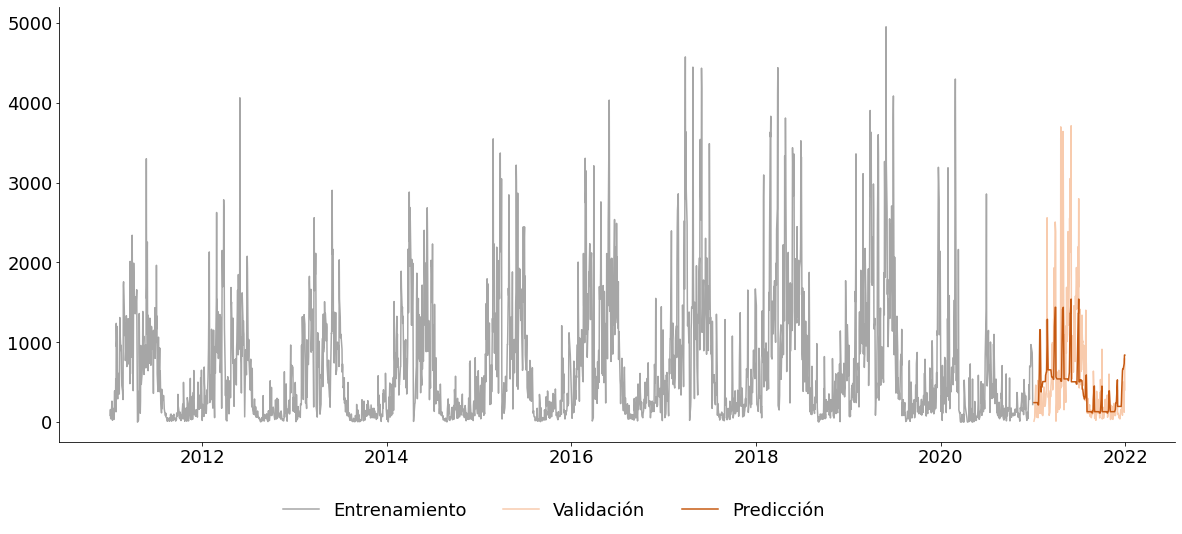

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_alquilador['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_alquilador['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_alquilador['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


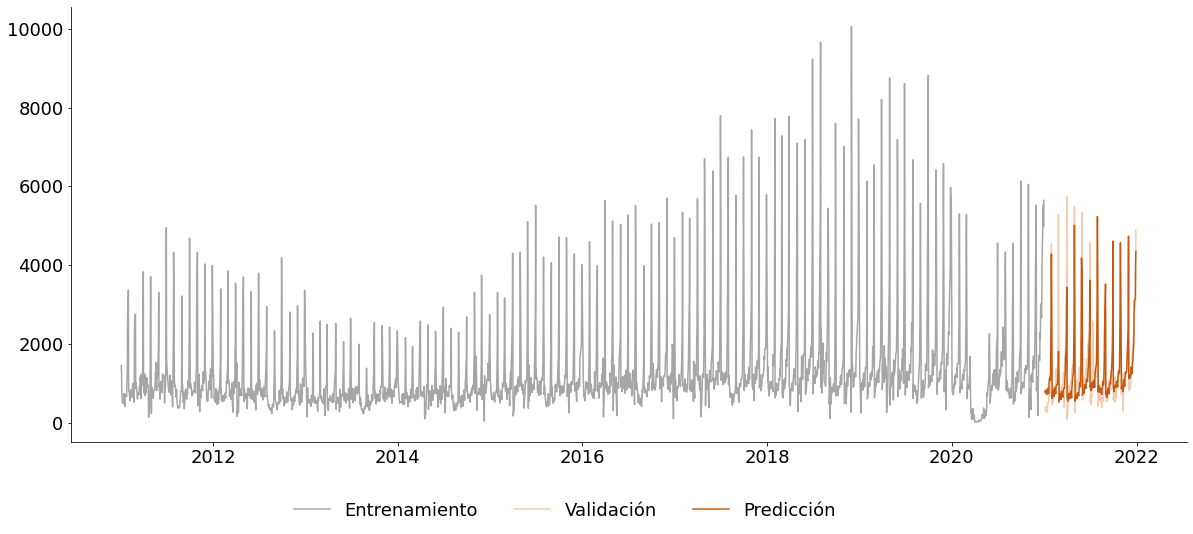

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_empresa['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_empresa['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_empresa['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


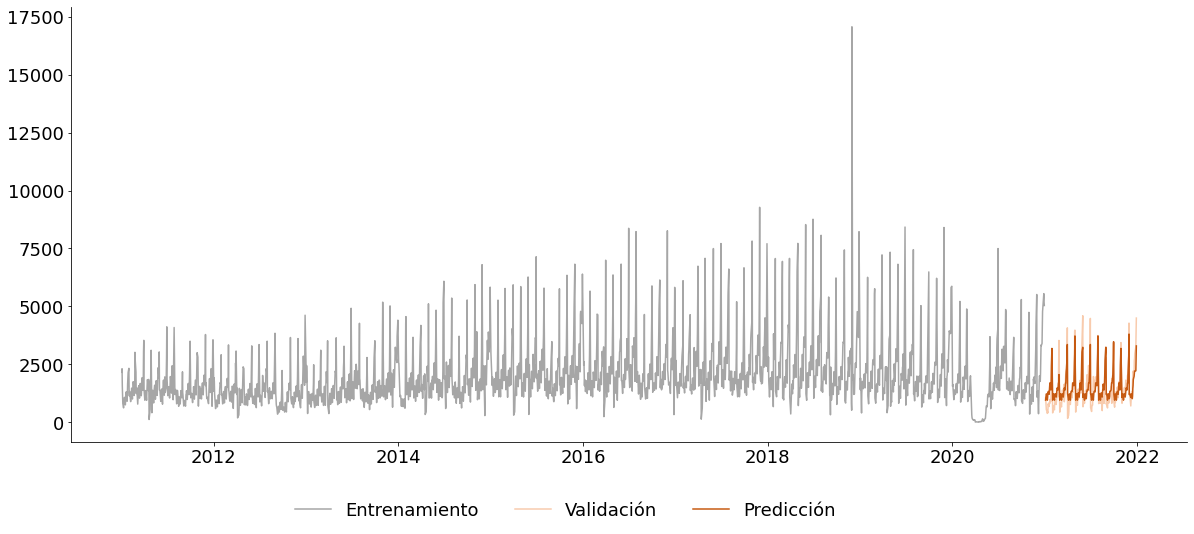

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento_particular['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion_particular['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_particular['prediccion'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
forecast_XGB_total = forecast_XGB_alquilador.merge(forecast_XGB_empresa, how='outer', on='date_matric')
forecast_XGB_total = forecast_XGB_total.merge(forecast_XGB_particular, how='outer', on='date_matric')

In [ ]:
forecast_XGB_total['prediccion_total'] = forecast_XGB_total['prediccion_x'] + forecast_XGB_total['prediccion_y'] + forecast_XGB_total['prediccion']
forecast_XGB_total.head()

,prediccion_x,prediccion_y,prediccion,prediccion_total
date_matric,,,,
2021-01-04,245.496933,815.608337,960.485962,2021.591187
2021-01-05,245.496933,753.559021,1075.478027,2074.533936
2021-01-07,245.496933,803.481567,1230.279419,2279.257812
2021-01-08,245.496933,803.481567,1230.279419,2279.257812
2021-01-11,245.496933,714.776733,960.485962,1920.759644


Entrenamiento: 2011-01-03 00:00:00  -  2020-12-30 00:00:00
Validación:  2021-01-04 00:00:00  -  2021-12-29 00:00:00


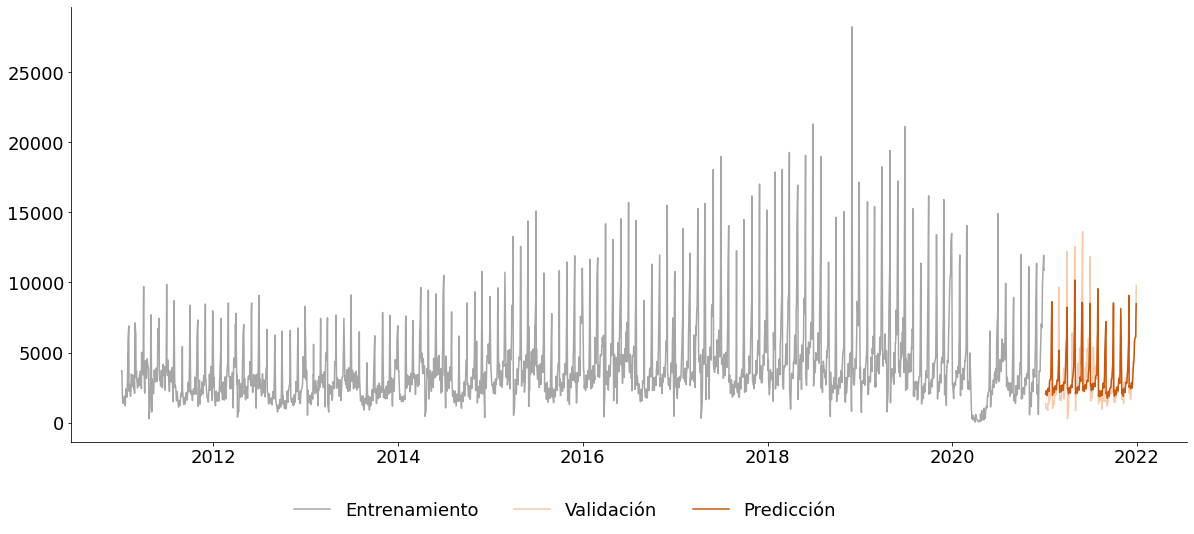

In [ ]:
rcParams['figure.figsize'] = 20, 8

plt.plot(entrenamiento['total'], label="Entrenamiento", color="#A6A6A6", linewidth=1.5)
plt.plot(validacion['total'], label="Validación", color="#F8CBAD", linewidth=1.5)
plt.plot(forecast_XGB_total['prediccion_total'], label="Predicción", color="#C65911", linewidth=1.5)

print('Entrenamiento:', entrenamiento.index.min(), ' - ', entrenamiento.index.max()) 
print('Validación: ', validacion.index.min(), ' - ', validacion.index.max())

plt.legend(bbox_to_anchor=(0.7, -0.1), prop={'size': 18}, ncol=3, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

sns.despine() # eliminar eje top y right
plt.show()

In [ ]:
# RMSE - 2 años
rms_XGB_day_LT = sqrt(mean_squared_error(validacion['total'],forecast_XGB_total['prediccion_total']))
print(rms_XGB_day_LT)

# RMSE - 3 meses
rms_XGB_day_MT = sqrt(mean_squared_error(validacion['total'][:66],forecast_XGB_total['prediccion_total'][:66]))
print(rms_XGB_day_MT)

# RMSE - 1 mes
rms_XGB_day_ST = sqrt(mean_squared_error(validacion['total'][:22],forecast_XGB_total['prediccion_total'][:22]))
print(rms_XGB_day_ST)

1141.8655086071699
1327.2374380996052
1105.154284172471
